In [21]:
using CSV, DataFrames
using PyPlot, LaTeXStrings, PyCall
using Interpolations, Distributions, Dierckx

@pyimport numpy as np
@pyimport scienceplots

In [22]:
duration = 100 # 全体の計算時間
dt = 0.1 # 刻み幅

whole_step = Int(duration/dt) # 全体のステップ数

U_W0 = 0.0 # 風速の初期値[m/s]
Ψ_W0 = 1.0* pi # 風向の初期値[rad]

# 風速が一定のとき
U_W_list = U_W0 * ones(Float64, whole_step+1)
# U_W_list = U_W0 .* ones(Float64, whole_step) .+ rand(Normal(0.0, 0.05), length(U_W_list))
Ψ_W_list = Ψ_W0 * ones(Float64, whole_step+1)

δ_ref =  35 * pi / 180.0 # 舵角[rad]
#舵角一定
δ_list = δ_ref * ones(Float64, whole_step+1)

n_p_ref = 21.21824 # プロペラ回転数[rps]
#回転数一定
n_p_list = n_p_ref * ones(Float64, whole_step+1)

x_0 = Vector(Float64[1.4, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, -3.0, 0.0, δ_list[1], n_p_list[1], 0.0, 0.0, 0.0])

X_F0 = 0.0
Y_F0 = 0.0
N_F0 = 0.0

X_F_list = X_F0 * ones(Float64, whole_step+1)
Y_F_list = Y_F0 * ones(Float64, whole_step+1)
N_F_list = N_F0 * ones(Float64, whole_step+1)


1001-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [23]:
# 船体に働く流体力
function X_H(u, v, r)
    U = sqrt((u^2) + ((v - r * x_G)^2))
    if U == 0
        β = 0.0
        r_dash = 0.0
        v_dash = 0.0
    else
        β = asin(-(v - r * x_G) / U)
        r_dash = r * L_pp / U
        v_dash = v / U
    end
    return 0.5 * ρ * L_pp * d * (U^2) * X_H_dash(v_dash, r_dash)
end

function Y_H(u, v, r)
    U = sqrt((u^2) + ((v - r * x_G)^2))
    if U == 0
        β = 0.0
        r_dash = 0.0
        v_dash = 0.0
    else
        β = asin(-(v - r * x_G) / U)
        r_dash = r * L_pp / U
        v_dash = v / U
    end
    return 0.5 * ρ * L_pp * d * (U^2) * Y_H_dash(v_dash, r_dash)
end

function N_H(u, v, r)
    U = sqrt((u^2) + ((v - r * x_G)^2))
    if U == 0
        β = 0.0
        r_dash = 0.0
        v_dash = 0.0
    else
        β = asin(-(v - r * x_G) / U)
        r_dash = r * L_pp / U
        v_dash = v / U
    end
    return 0.5 * ρ * (L_pp^2) * d * (U^2) * N_H_dash(v_dash, r_dash)
end

# 船体に働く流体力(無次元)
function X_H_dash(v_dash, r_dash)
    return -R_0_dash + X_vv_dash*(v_dash)^2 + X_vr_dash*v_dash*r_dash + X_rr_dash*(r_dash^2) + X_vvvv_dash*(v_dash^4)
end

function Y_H_dash(v_dash, r_dash)
    return Y_v_dash*v_dash + Y_r_dash*r_dash + Y_vvr_dash*(v_dash)^2*r_dash + Y_vrr_dash*v_dash*r_dash^2 + Y_vvv_dash*(v_dash^3) + Y_rrr_dash*r_dash^3
end

function N_H_dash(v_dash, r_dash)
    return N_v_dash*v_dash + N_r_dash*r_dash + N_vvr_dash*(v_dash^2)*r_dash + N_vrr_dash*v_dash*r_dash^2 + N_vvv_dash*(v_dash^3) + N_rrr_dash*r_dash^3
end

# 舵に働く力
function X_R(u, v, r, δ, n_p)
    return -(1 - t_R) * F_N(u, v, r, δ, n_p) * sin(δ)
end

function Y_R(u, v, r, δ, n_p)
    return -(1 + a_H) * F_N(u, v, r, δ, n_p) * cos(δ)
end

function N_R(u, v, r, δ, n_p)
    return -(x_R + a_H * x_H) * F_N(u, v, r, δ, n_p) * cos(δ)
end

function F_N(u, v, r, δ, n_p)
    U = sqrt((u^2) + ((v - r * x_G)^2))
    if U == 0
        β = 0.0
        r_dash = 0.0
        v_dash = 0.0
    else
        β = asin(-(v - r * x_G) / U)
        r_dash = r * L_pp / U
        v_dash = v / U
    end
    w_P = w_P0 * exp(-4.0 * (β - x_P * r_dash)^2)
    u_p = (1 - w_P) * u
    if J(u, v, r, n_p) == 0.0
        u_R = sqrt(η * (κ * ϵ * 8.0 * k_0 * n_p^2 * D_p^4 / pi)^2)
    else
        u_R = u * (1.0 - w_P) * ϵ * sqrt(η * (1.0 + κ * (sqrt(1.0 + 8.0 * K_T(u, v, r, n_p) / (pi * J(u, v, r, n_p)^2)) - 1))^2 + (1 - η))
    end
    β_R = β - l_R * r_dash
    if β_R < 0.0
        γ_R = γ_R_minus
    else
        γ_R = γ_R_plus
    end 
    v_R = U * γ_R * β_R
    α_R = δ - atan(v_R, u_R)
    U_R = sqrt(u_R^2 + v_R^2)
    return 0.5 * ρ * A_R * (U_R^2) * f_α * sin(α_R)
end

# プロペラに働く力
function X_P(u, v, r, δ, n_p)
    return (1 - t_P) * T_P(u, v, r, n_p)
end

function K_T(u, v, r, n_p)
    return k_0 + k_1 * J(u, v, r, n_p) + k_2 * (J(u, v, r, n_p)^2)
end

function J(u, v, r, n_p)
    U = sqrt((u^2) + ((v - r * x_G)^2))
    if U == 0
        β = 0.0
        r_dash = 0.0
        v_dash = 0.0
    else
        β = asin(-(v - r * x_G) / U)
        r_dash = r * L_pp / U
        v_dash = v / U
    end
    w_P = w_P0 * exp(-4.0 * (β - x_P * r_dash)^2)
    return u * (1 - w_P) / (n_p * D_p)
end

function T_P(u, v, r, n_p)
    return K_T(u, v, r, n_p) * ρ * n_p^2 * D_p^4
end

function X_wind(u, v, ψ, U_W, Ψ_W)
    ρ_air = 1.225
    u_A = u + U_W*cos(Ψ_W-ψ)
    v_A = v + U_W*sin(Ψ_W-ψ)
    U_A = sqrt(u_A^2 + v_A^2)
    Ψ_A = -atan(v_A, u_A)
    Ψ_A = mod(Ψ_A, 2 * π)
    return ρ_air * A_F * spl_C_X(Ψ_A) / 2 * U_A^2
end

function Y_wind(u, v, ψ, U_W, Ψ_W)
    ρ_air = 1.225
    u_A = u + U_W*cos(Ψ_W-ψ)
    v_A = v + U_W*sin(Ψ_W-ψ)
    U_A = sqrt(u_A^2 + v_A^2)
    Ψ_A = -atan(v_A, u_A)
    Ψ_A = mod(Ψ_A, 2 * π)
    return ρ_air * A_L * spl_C_Y(Ψ_A) / 2 * U_A^2
end

function N_wind(u, v, ψ, U_W, Ψ_W)
    ρ_air = 1.225
    u_A = u + U_W*cos(Ψ_W-ψ)
    v_A = v + U_W*sin(Ψ_W-ψ)
    U_A = sqrt(u_A^2 + v_A^2)
    Ψ_A = -atan(v_A, u_A)
    Ψ_A = mod(Ψ_A, 2 * π)
    return ρ_air * A_L * L_pp * spl_C_N(Ψ_A) / 2 * U_A^2
end

N_wind (generic function with 1 method)

In [24]:
function wind_force_and_moment_coefficients(
    ψ_A,
    L_pp,
    B,
    A_OD,
    A_F,
    A_L,
    H_BR,
    H_C,
    C,
)
    #C_LF1の場合で調整
    C_CF = 0.404 + 0.368 * A_F / (B * H_BR) + 0.902 * H_BR / L_pp

    if deg2rad(0) <= ψ_A <= deg2rad(90)
        C_LF = -0.992 + 0.507 * A_L / (L_pp * B) + 1.162 * C / L_pp
        C_XLI = 0.458 + 3.245 * A_L / (L_pp * H_BR) - 2.313 * A_F / (B * H_BR)
        C_ALF = -0.585 - 0.906 * A_OD / A_L + 3.239 * B / L_pp
        C_YLI = pi * A_L / L_pp^2 + 0.116 + 3.345 * A_F / (L_pp * B)

        C_X = C_LF * cos(ψ_A) + C_XLI * (sin(ψ_A) - sin(ψ_A) * cos(ψ_A)^2 / 2) * sin(ψ_A) * cos(ψ_A) + C_ALF * sin(ψ_A) * cos(ψ_A)^3
        C_Y = C_CF * sin(ψ_A)^2 + C_YLI * (cos(ψ_A) + sin(ψ_A)^2 * cos(ψ_A) / 2) * sin(ψ_A) * cos(ψ_A)
        C_N = C_Y * (0.297 * C / L_pp - 0.149 * (ψ_A - deg2rad(90)))

    elseif deg2rad(90) < ψ_A <= deg2rad(180)
        C_LF =
            0.018 - 5.091 * B / L_pp + 10.367 * H_C / L_pp - 3.011 * A_OD / L_pp^2 -
            0.341 * A_F / B^2
        C_XLI =
            -1.901 + 12.727 * A_L / (L_pp * H_BR) + 24.407 * A_F / A_L -
            40.310 * B / L_pp - 0.341 * A_F / (B * H_BR)
        C_ALF = -0.314 - 1.117 * A_OD / A_L
        C_YLI = pi * A_L / L_pp^2 + 0.446 + 2.192 * A_F / L_pp^2

        C_X = C_LF * cos(ψ_A) + C_XLI * (sin(ψ_A) - sin(ψ_A) * cos(ψ_A)^2 / 2) * sin(ψ_A) * cos(ψ_A) + C_ALF * sin(ψ_A) * cos(ψ_A)^3
        C_Y = C_CF * sin(ψ_A)^2 + C_YLI * (cos(ψ_A) + sin(ψ_A)^2 * cos(ψ_A) / 2) * sin(ψ_A) * cos(ψ_A)
        C_N = C_Y * (0.297 * C / L_pp - 0.149 * (ψ_A - deg2rad(90)))

    elseif deg2rad(180) < ψ_A <= deg2rad(270)
        C_LF =
            0.018 - 5.091 * B / L_pp + 10.367 * H_C / L_pp - 3.011 * A_OD / L_pp^2 -
            0.341 * A_F / B^2
        C_XLI =
            -1.901 + 12.727 * A_L / (L_pp * H_BR) + 24.407 * A_F / A_L -
            40.310 * B / L_pp - 0.341 * A_F / (B * H_BR)
        C_ALF = -0.314 - 1.117 * A_OD / A_L
        C_YLI = pi * A_L / L_pp^2 + 0.446 + 2.192 * A_F / L_pp^2
        ψ_A = 2*pi - ψ_A
        C_X = (C_LF * cos(ψ_A) + C_XLI * (sin(ψ_A) - sin(ψ_A) * cos(ψ_A)^2 / 2) * sin(ψ_A) * cos(ψ_A) + C_ALF * sin(ψ_A) * cos(ψ_A)^3)
        C_Y = -(C_CF * sin(ψ_A)^2 + C_YLI * (cos(ψ_A) + sin(ψ_A)^2 * cos(ψ_A) / 2) * sin(ψ_A) * cos(ψ_A))
        C_N = (C_Y * (0.297 * C / L_pp - 0.149 * (ψ_A - deg2rad(90))))
    
    elseif deg2rad(270) < ψ_A <= deg2rad(360)
        C_LF = -0.992 + 0.507 * A_L / (L_pp * B) + 1.162 * C / L_pp
        C_XLI = 0.458 + 3.245 * A_L / (L_pp * H_BR) - 2.313 * A_F / (B * H_BR)
        C_ALF = -0.585 - 0.906 * A_OD / A_L + 3.239 * B / L_pp
        C_YLI = pi * A_L / L_pp^2 + 0.116 + 3.345 * A_F / (L_pp * B)

        ψ_A = 2*pi - ψ_A
        C_X = (C_LF * cos(ψ_A) + C_XLI * (sin(ψ_A) - sin(ψ_A) * cos(ψ_A)^2 / 2) * sin(ψ_A) * cos(ψ_A) + C_ALF * sin(ψ_A) * cos(ψ_A)^3)
        C_Y = -(C_CF * sin(ψ_A)^2 + C_YLI * (cos(ψ_A) + sin(ψ_A)^2 * cos(ψ_A) / 2) * sin(ψ_A) * cos(ψ_A))
        C_N = (C_Y * (0.297 * C / L_pp - 0.149 * (ψ_A - deg2rad(90))))
    end
    
    C_X, C_Y, C_N
end

wind_force_and_moment_coefficients (generic function with 1 method)

In [25]:
ρ = 1025.0
L_pp = 7.00  # 船長Lpp[m]
B = 1.27  # 船幅[m]
d = 0.46  # 喫水[m]
nabla = 3.27  # 排水量[m^3]
x_G = 0.25  # 重心位置[m]
# C_b = 0.810  # 方形係数[-]
D_p = 0.216  # プロペラ直径[m]
H_R = 0.345  # 舵高さ[m]
A_R = 0.0539  # 舵断面積[m^2]
t_P = 0.220  # 推力減少率
w_P0 = 0.40  # 有効伴流率
m_x_dash = 0.022  # 付加質量x(無次元)
m_y_dash = 0.223  # 付加質量y(無次元)
J_z_dash = 0.011  # 付加質量Izz(無次元)
t_R = 0.387  # 操縦抵抗減少率
x_R_dash = -0.500  # 舵の相対位置
a_H = 0.312  # 舵力増加係数
x_H_dash = -0.464  # 舵力増分作用位置
γ_R_minus = 0.395  # 整流係数
γ_R_plus = 0.640  # 整流係数
l_r_dash = -0.710  # 船長に対する舵位置
x_P_dash = -0.690  # 船長に対するプロペラ位置
ϵ = 1.09  # プロペラ・舵位置伴流係数比
κ = 0.50  # 修正係数
f_α = 2.747  # 直圧力勾配係数

L_pp = L_pp  # 船長Lpp[m]
B = B  # 船幅[m]
d = d  # 喫水[m]
x_G = x_G  # 重心位置[]
D_p = D_p  # プロペラ直径[m]
m = ρ * nabla  # 質量(無次元化)[kg]
I_zG = ρ * nabla * ((0.25 * L_pp)^2)  # 慣性モーメント[-]
A_R = A_R  # 船の断面に対する舵面積比[-]
η = D_p / H_R  # プロペラ直径に対する舵高さ(Dp/H)
m_x = (0.5 * ρ * (L_pp^2) * d) * m_x_dash  # 付加質量x(無次元)
m_y = (0.5 * ρ * (L_pp^2) * d) * m_y_dash  # 付加質量y(無次元)
J_z = (0.5 * ρ * (L_pp^4) * d) * J_z_dash  # 付加質量Izz(無次元)
f_α = f_α # 直圧力勾配係数
ϵ = ϵ  # プロペラ・舵位置伴流係数比
t_R = t_R  # 操縦抵抗減少率
x_R = x_R_dash * L_pp  # 舵の位置
a_H = a_H  # 舵力増加係数
x_H = x_H_dash * L_pp  # 舵力増分作用位置
γ_R_minus = γ_R_minus  # 整流係数
γ_R_plus = γ_R_plus  # 整流係数
l_R = l_r_dash  # 船長に対する舵位置
κ = κ  # 修正係数
t_P = t_P  # 推力減少率
w_P0 = w_P0  # 有効伴流率
x_P = x_P_dash  # 船長に対するプロペラ位置

const k_0 = 0.2931
const k_1 = -0.2753
const k_2 = -0.1385

L_f = 3.0 # センサー位置(船首)
L_t = 3.0 # センサー位置(船尾)

D = 0.6563 # 深さ[m]
A_OD = 0.65 # デッキ上の構造物の側面投影面積[m^2]
H_BR = 0.85 # 喫水からブリッジ主要構造物の最高位[m]
H_C = 0.235 # 喫水から側面積中心までの高さ[m]
C = 0.0 # 船体中心から側面積中心までの前後方向座標(船首方向を正)[m]

A_OD = A_OD # デッキ上の構造物の側面投影面積[m^2]
A_F = (D - d) * B  # 船体の正面投影面積[m^2]
A_L = (D - d) * L_pp # 船体の側面投影面積[m^2]
H_BR = H_BR # 喫水からブリッジ主要構造物の最高位[m]
H_C = H_C # 喫水から側面積中心までの高さ[m]
C = C # 船体中心から側面積中心までの前後方向座標[m]

ψ_A_vec = deg2rad.(collect(0:10:360))
C_X_vec = Array{Float64}(undef, length(ψ_A_vec))
C_Y_vec = Array{Float64}(undef, length(ψ_A_vec))
C_N_vec = Array{Float64}(undef, length(ψ_A_vec))
for (index, ψ_A) in enumerate(ψ_A_vec)
    C_X, C_Y, C_N = wind_force_and_moment_coefficients(
        ψ_A,
        L_pp,
        B,
        A_OD,
        A_F,
        A_L,
        H_BR,
        H_C,
        C,
    )
    C_X_vec[index] = C_X
    C_Y_vec[index] = C_Y
    C_N_vec[index] = C_N
end
spl_C_X = Spline1D(ψ_A_vec, C_X_vec)
spl_C_Y = Spline1D(ψ_A_vec, C_Y_vec)
spl_C_N = Spline1D(ψ_A_vec, C_N_vec)

Spline1D(knots=[0.0,0.349066 … 5.93412,6.28319] (35 elements), k=3, extrapolation="nearest", residual=0.0)

In [26]:
p = [
    [0.0200, -0.0799, 0.1016, -0.0176, 0.5704, -0.3711, 0.0720, -1.0535, 0.2070, -0.2556, 0.0220, -0.1097, -0.0527, -0.0533, -0.2863, -0.0206, -0.0196],
    [0.022, -0.040, 0.002, 0.011, 0.771, -0.315, 0.083, -1.607, 0.379, -0.391, 0.008, -0.137, -0.049, -0.030, -0.294, 0.055, -0.013]
] 

2-element Vector{Vector{Float64}}:
 [0.02, -0.0799, 0.1016, -0.0176, 0.5704, -0.3711, 0.072, -1.0535, 0.207, -0.2556, 0.022, -0.1097, -0.0527, -0.0533, -0.2863, -0.0206, -0.0196]
 [0.022, -0.04, 0.002, 0.011, 0.771, -0.315, 0.083, -1.607, 0.379, -0.391, 0.008, -0.137, -0.049, -0.03, -0.294, 0.055, -0.013]

In [27]:
q=2
R_0_dash = p[q][1]
X_vv_dash = p[q][2]
X_vr_dash = p[q][3]
X_rr_dash = p[q][4]
X_vvvv_dash = p[q][5]
Y_v_dash = p[q][6]
Y_r_dash = p[q][7]
Y_vvv_dash = p[q][8]
Y_vvr_dash = p[q][9]
Y_vrr_dash = p[q][10]
Y_rrr_dash = p[q][11]
N_v_dash = p[q][12]
N_r_dash = p[q][13]
N_vvv_dash = p[q][14]
N_vvr_dash = p[q][15]
N_vrr_dash = p[q][16]
N_rrr_dash = p[q][17]

-0.013

In [28]:
function MMG(x_0, X_F, Y_F, N_F, X_wind, Y_wind, N_wind, δ, n_p)
    u = x_0[1] + dt * ((X_H(x_0[1], x_0[2], x_0[3]) + X_R(x_0[1], x_0[2], x_0[3], δ, n_p) + X_P(x_0[1], x_0[2], x_0[3], δ, n_p) + X_F + X_wind + (m + m_y) * x_0[2] * x_0[3]) / (m + m_x))
    v = x_0[2] + dt * ((Y_H(x_0[1], x_0[2], x_0[3]) + Y_R(x_0[1], x_0[2], x_0[3], δ, n_p) + Y_F + Y_wind - (m + m_x) * x_0[1] * x_0[3]) / (m + m_y))
    r = x_0[3] + dt * ((N_H(x_0[1], x_0[2], x_0[3]) + N_R(x_0[1], x_0[2], x_0[3], δ, n_p) + N_F + N_wind) / (I_zG + J_z))
    x = x_0[4] + dt * (x_0[1] * cos(x_0[6]) - x_0[2] * sin(x_0[6]))
    y = x_0[5] + dt * (x_0[1] * sin(x_0[6]) + x_0[2] * cos(x_0[6]))
    ψ = x_0[6] + dt * (x_0[3])
    x1 = x + L_f * cos(ψ)
    y1 = y + L_f * sin(ψ)
    x2 = x + L_t * cos(ψ + pi)
    y2 = y + L_t * sin(ψ + pi)
    return u, v, r, x, y, ψ, x1, y1, x2, y2, δ, n_p
end

MMG (generic function with 1 method)

In [29]:
cols = Int(duration/dt) + 1
df_x = DataFrame(
    time = collect(0:dt:duration),
    u = zeros(cols),
    v = zeros(cols),
    r = zeros(cols),
    x = zeros(cols),
    y = zeros(cols),
    ψ = zeros(cols),
    x1 = zeros(cols),
    y1 = zeros(cols),
    x2 = zeros(cols),
    y2 = zeros(cols),
    δ = zeros(cols),
    n_p = zeros(cols),
    X_wind = zeros(cols),
    Y_wind = zeros(cols),
    N_wind = zeros(cols),
    U_W = zeros(cols),
    Ψ_W = zeros(cols),
    X_F = zeros(cols),
    Y_F = zeros(cols),
    N_F = zeros(cols)
)

#初期値をデータフレームへ
df_x[1, 2:13] .= x_0[1:12]

for t in 1 : Int(duration/dt)
    U_W_t = U_W_list[t]
    Ψ_W_t = Ψ_W_list[t]

    X_F_t = X_F_list[t]
    Y_F_t = Y_F_list[t]
    N_F_t = N_F_list[t]

    x_F = X_F_t*cos(x_0[6]) + Y_F_t*sin(x_0[6])
    y_F = -X_F_t*sin(x_0[6]) + Y_F_t*cos(x_0[6]) 
    n_F = N_F_t

    x_wind = X_wind(x_0[1], x_0[2], x_0[6], U_W_t, Ψ_W_t)
    y_wind = Y_wind(x_0[1], x_0[2], x_0[6], U_W_t, Ψ_W_t)
    n_wind = N_wind(x_0[1], x_0[2], x_0[6], U_W_t, Ψ_W_t)   

    x_val = MMG(x_0, x_F, y_F, n_F, x_wind, y_wind, n_wind, δ_list[t], n_p_list[t])

    df_x[t+1, 2:13] .= x_val
    df_x[t, 14:16] .= [x_wind, y_wind, n_wind]
    df_x[t, 17:18] .= [U_W_t, Ψ_W_t]
    df_x[t, 19:21] .= [x_F, y_F, n_F]

    x_0 = collect(x_val) 
end

CSV.write("./MPC/observation/obs_EF.csv", df_x)
obs = CSV.read("./MPC/observation/obs_EF.csv", DataFrame)

Row,time,u,v,r,x,y,ψ,x1,y1,x2,y2,δ,n_p,X_wind,Y_wind,N_wind,U_W,Ψ_W,X_F,Y_F,N_F
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,1.4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,-3.0,0.0,0.610865,21.2182,-0.273438,-3.54939e-19,3.72686e-18,0.0,3.14159,0.0,0.0,0.0
2,0.1,1.40146,-0.00322616,0.00398929,0.14,0.0,0.0,3.14,0.0,-2.86,3.67394e-16,0.610865,21.2182,-0.274308,0.00111943,0.00186575,0.0,3.14159,0.0,0.0,0.0
3,0.2,1.40292,-0.00662959,0.0078472,0.280146,-0.000322616,0.000398929,3.28015,0.000874172,-2.71985,-0.0015194,0.610865,21.2182,-0.275201,0.00231521,0.00385058,0.0,3.14159,0.0,0.0,0.0
4,0.3,1.40439,-0.0102029,0.0115836,0.420438,-0.000929608,0.00118365,3.42044,0.00262134,-2.57956,-0.00448056,0.610865,21.2182,-0.276111,0.00358687,0.00595237,0.0,3.14159,0.0,0.0,0.0
5,0.4,1.40585,-0.0139389,0.0152074,0.560878,-0.00178367,0.00234201,3.56087,0.00524235,-2.43911,-0.00880968,0.610865,21.2182,-0.277036,0.00493395,0.00816907,0.0,3.14159,0.0,0.0,0.0
6,0.5,1.4073,-0.0178308,0.0187269,0.701465,-0.0028483,0.00386275,3.70144,0.00873991,-2.29851,-0.0144365,0.610865,21.2182,-0.277972,0.00635604,0.0104987,0.0,3.14159,0.0,0.0,0.0
7,0.6,1.40873,-0.0218718,0.0221496,0.842201,-0.00408776,0.00573544,3.84215,0.0131185,-2.15775,-0.021294,0.610865,21.2182,-0.278917,0.00785272,0.0129391,0.0,3.14159,0.0,0.0,0.0
8,0.7,1.41014,-0.0260556,0.0254825,0.983085,-0.00546694,0.0079504,3.98299,0.018384,-2.01682,-0.0293179,0.610865,21.2182,-0.279866,0.00942355,0.0154884,0.0,3.14159,0.0,0.0,0.0
9,0.8,1.41152,-0.0303758,0.0287316,1.12411,-0.00695131,0.0104986,4.12395,0.0245441,-1.87572,-0.0384467,0.610865,21.2182,-0.280817,0.011068,0.0181445,0.0,3.14159,0.0,0.0,0.0


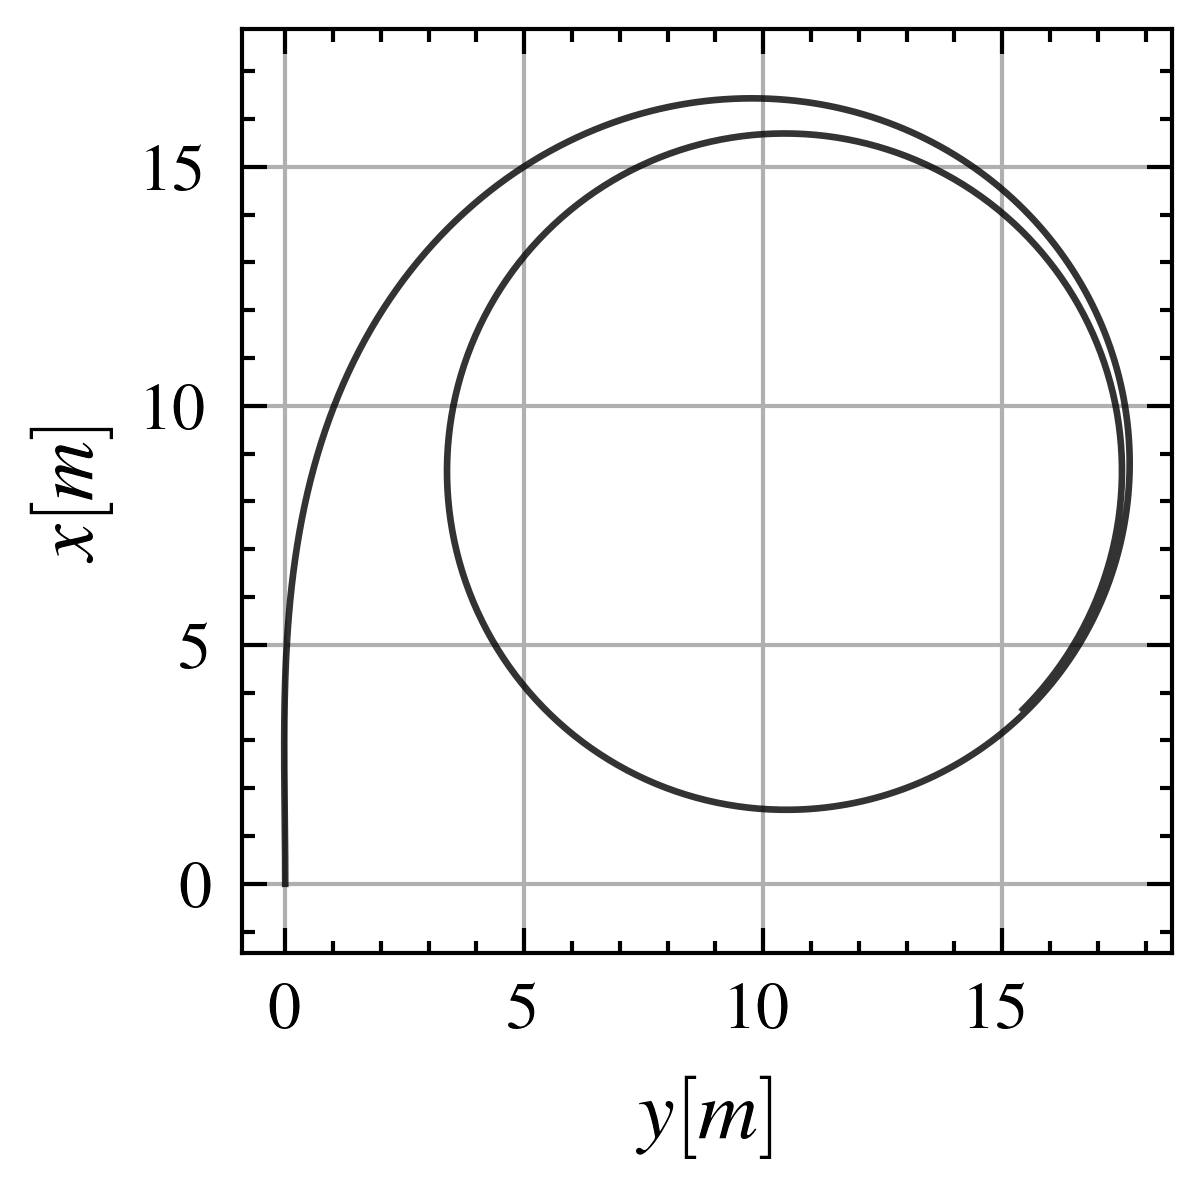

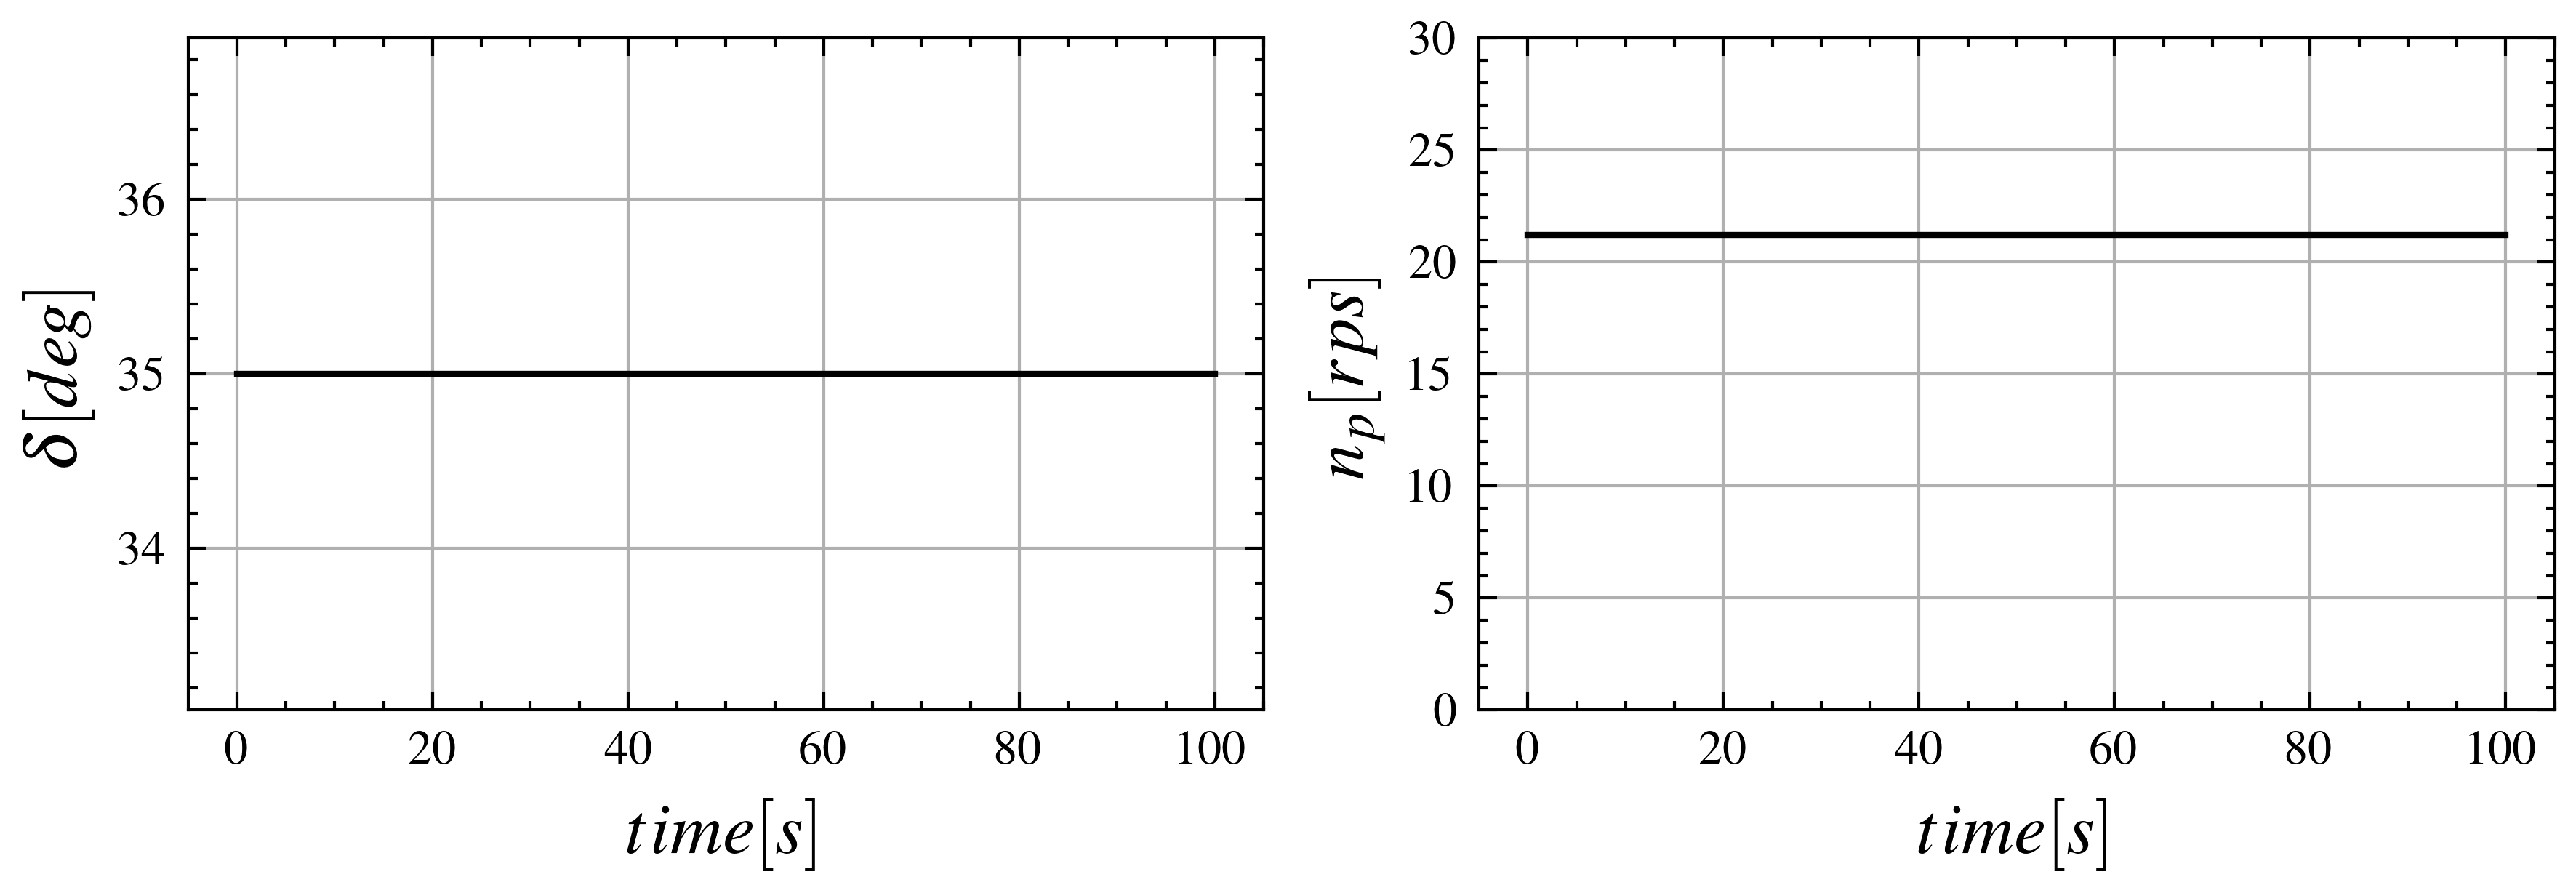

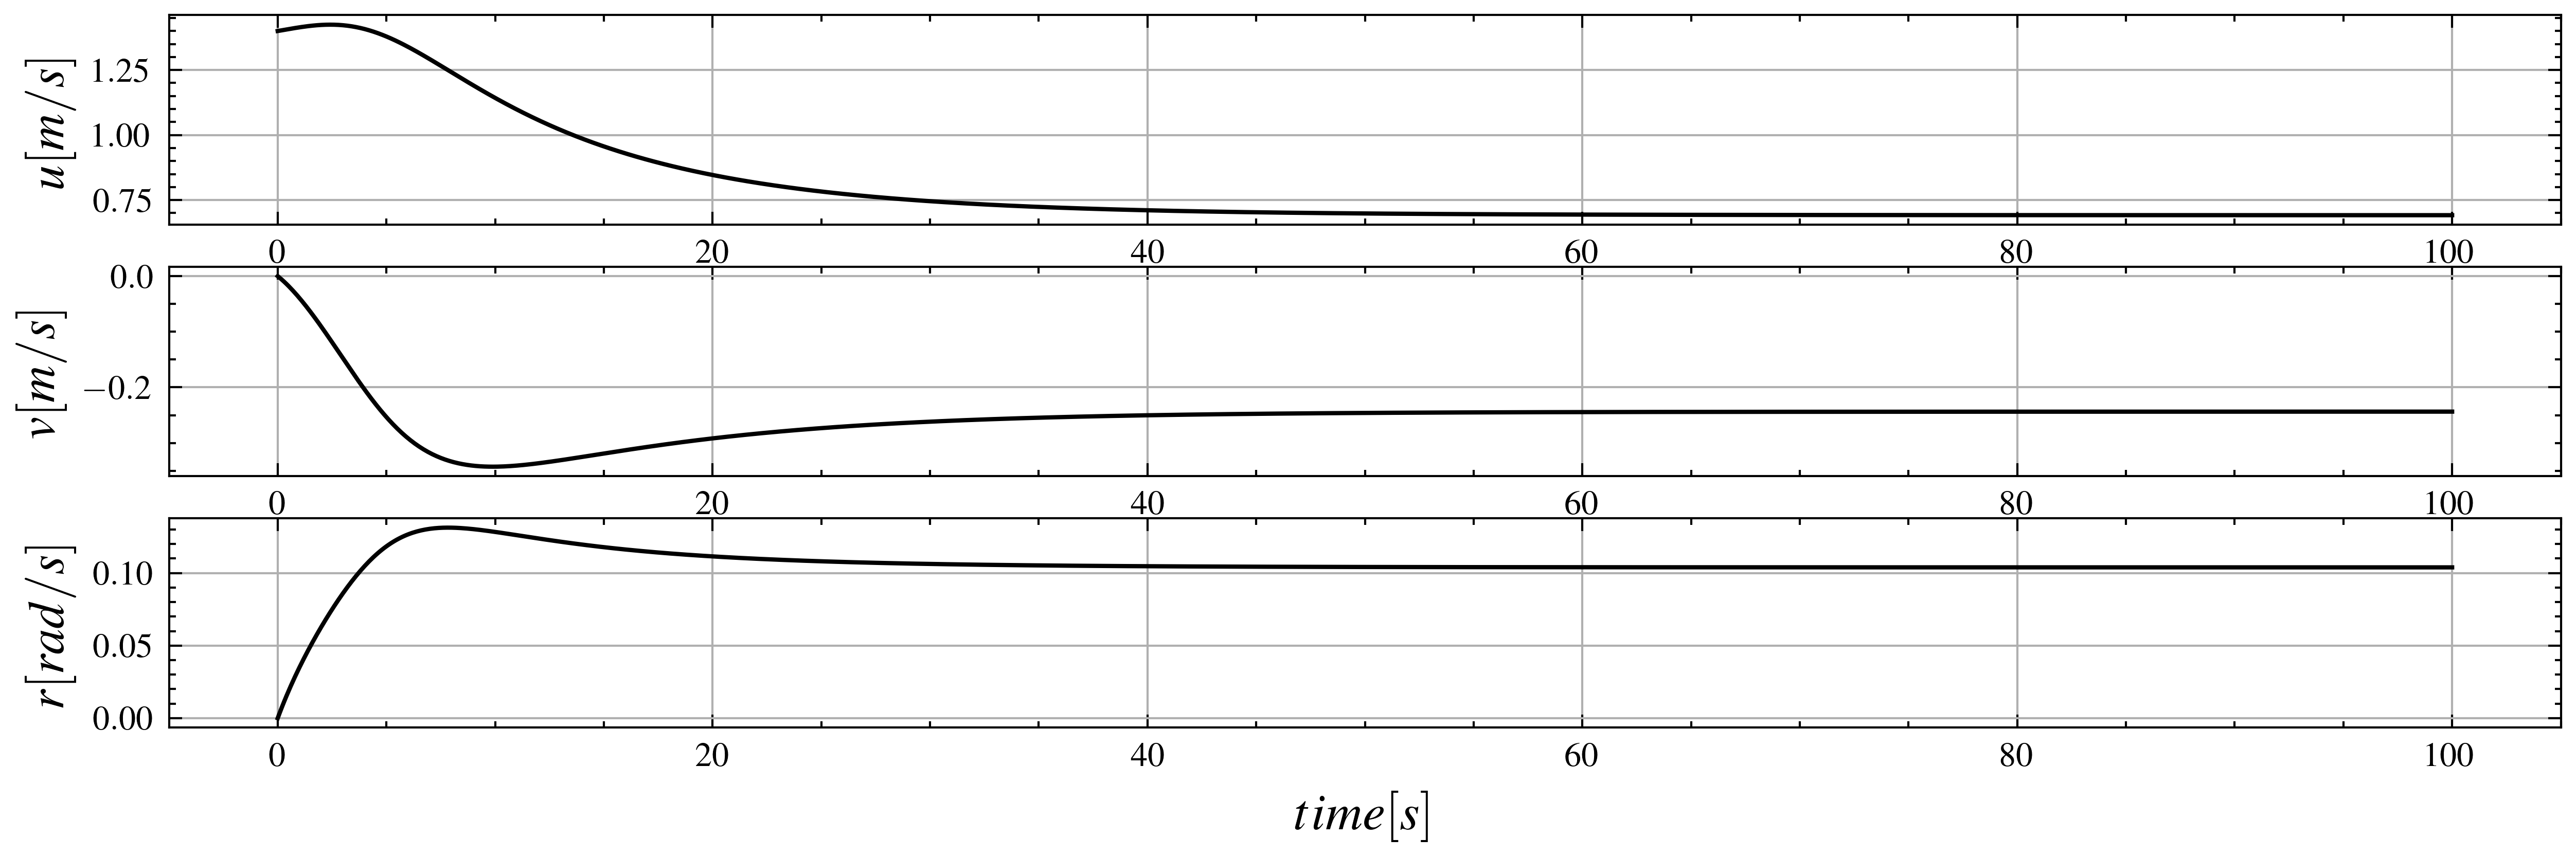

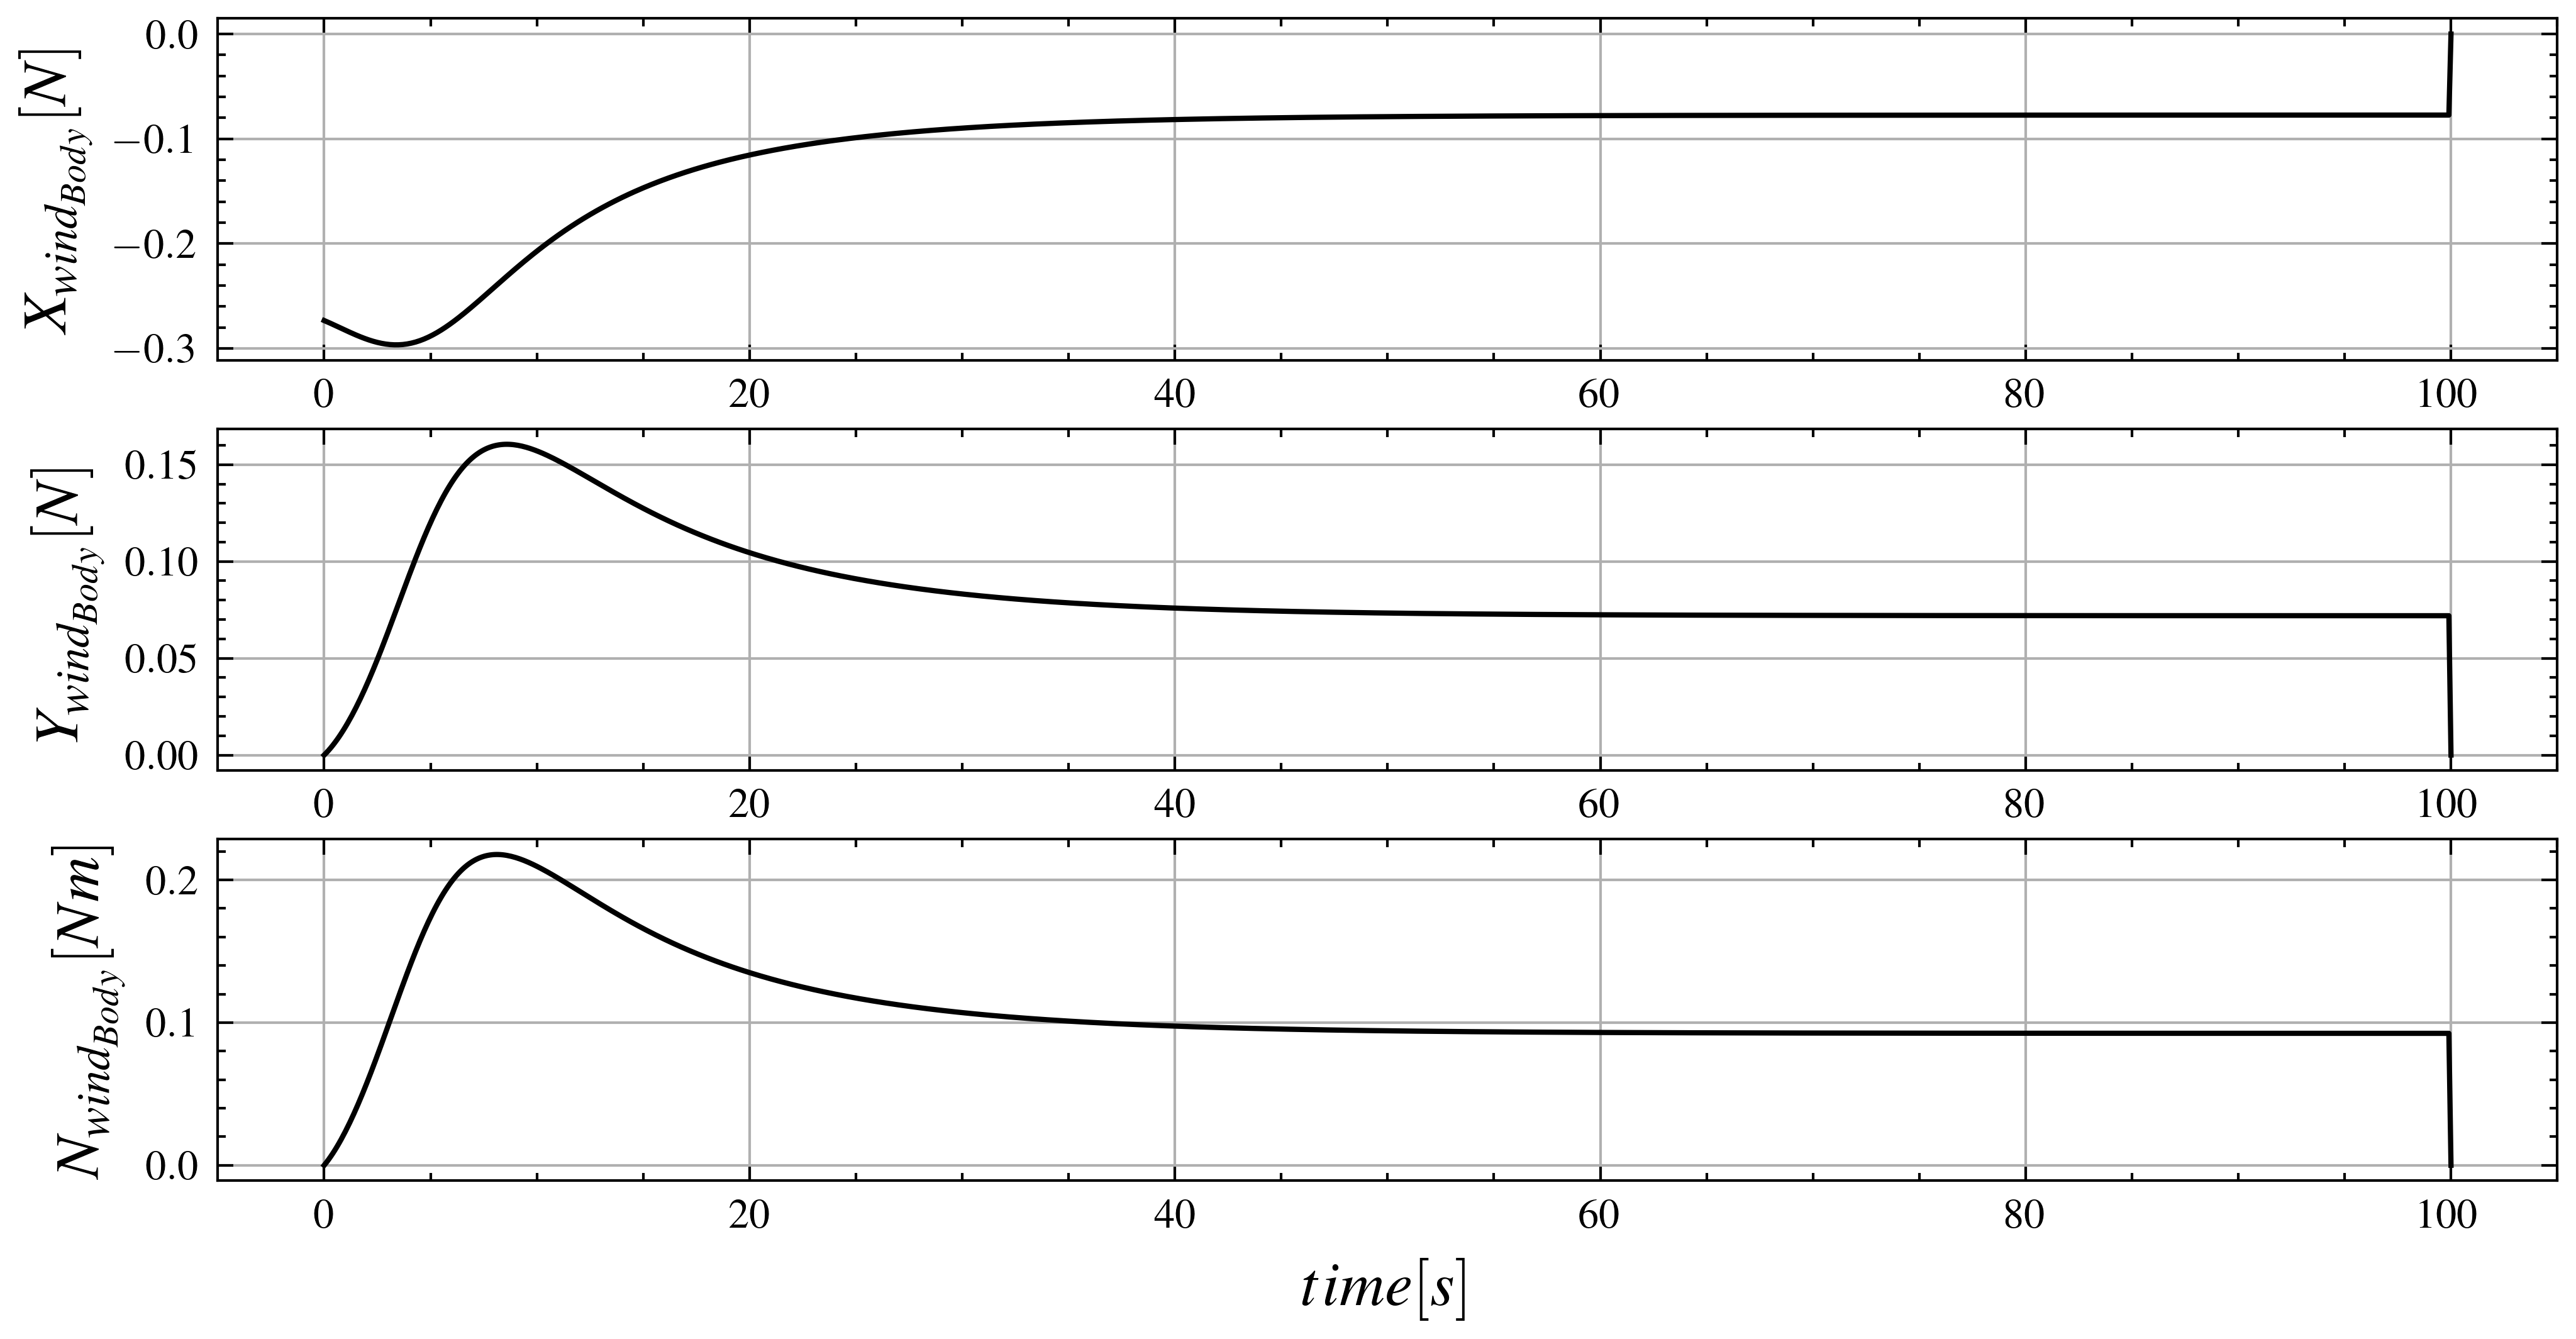

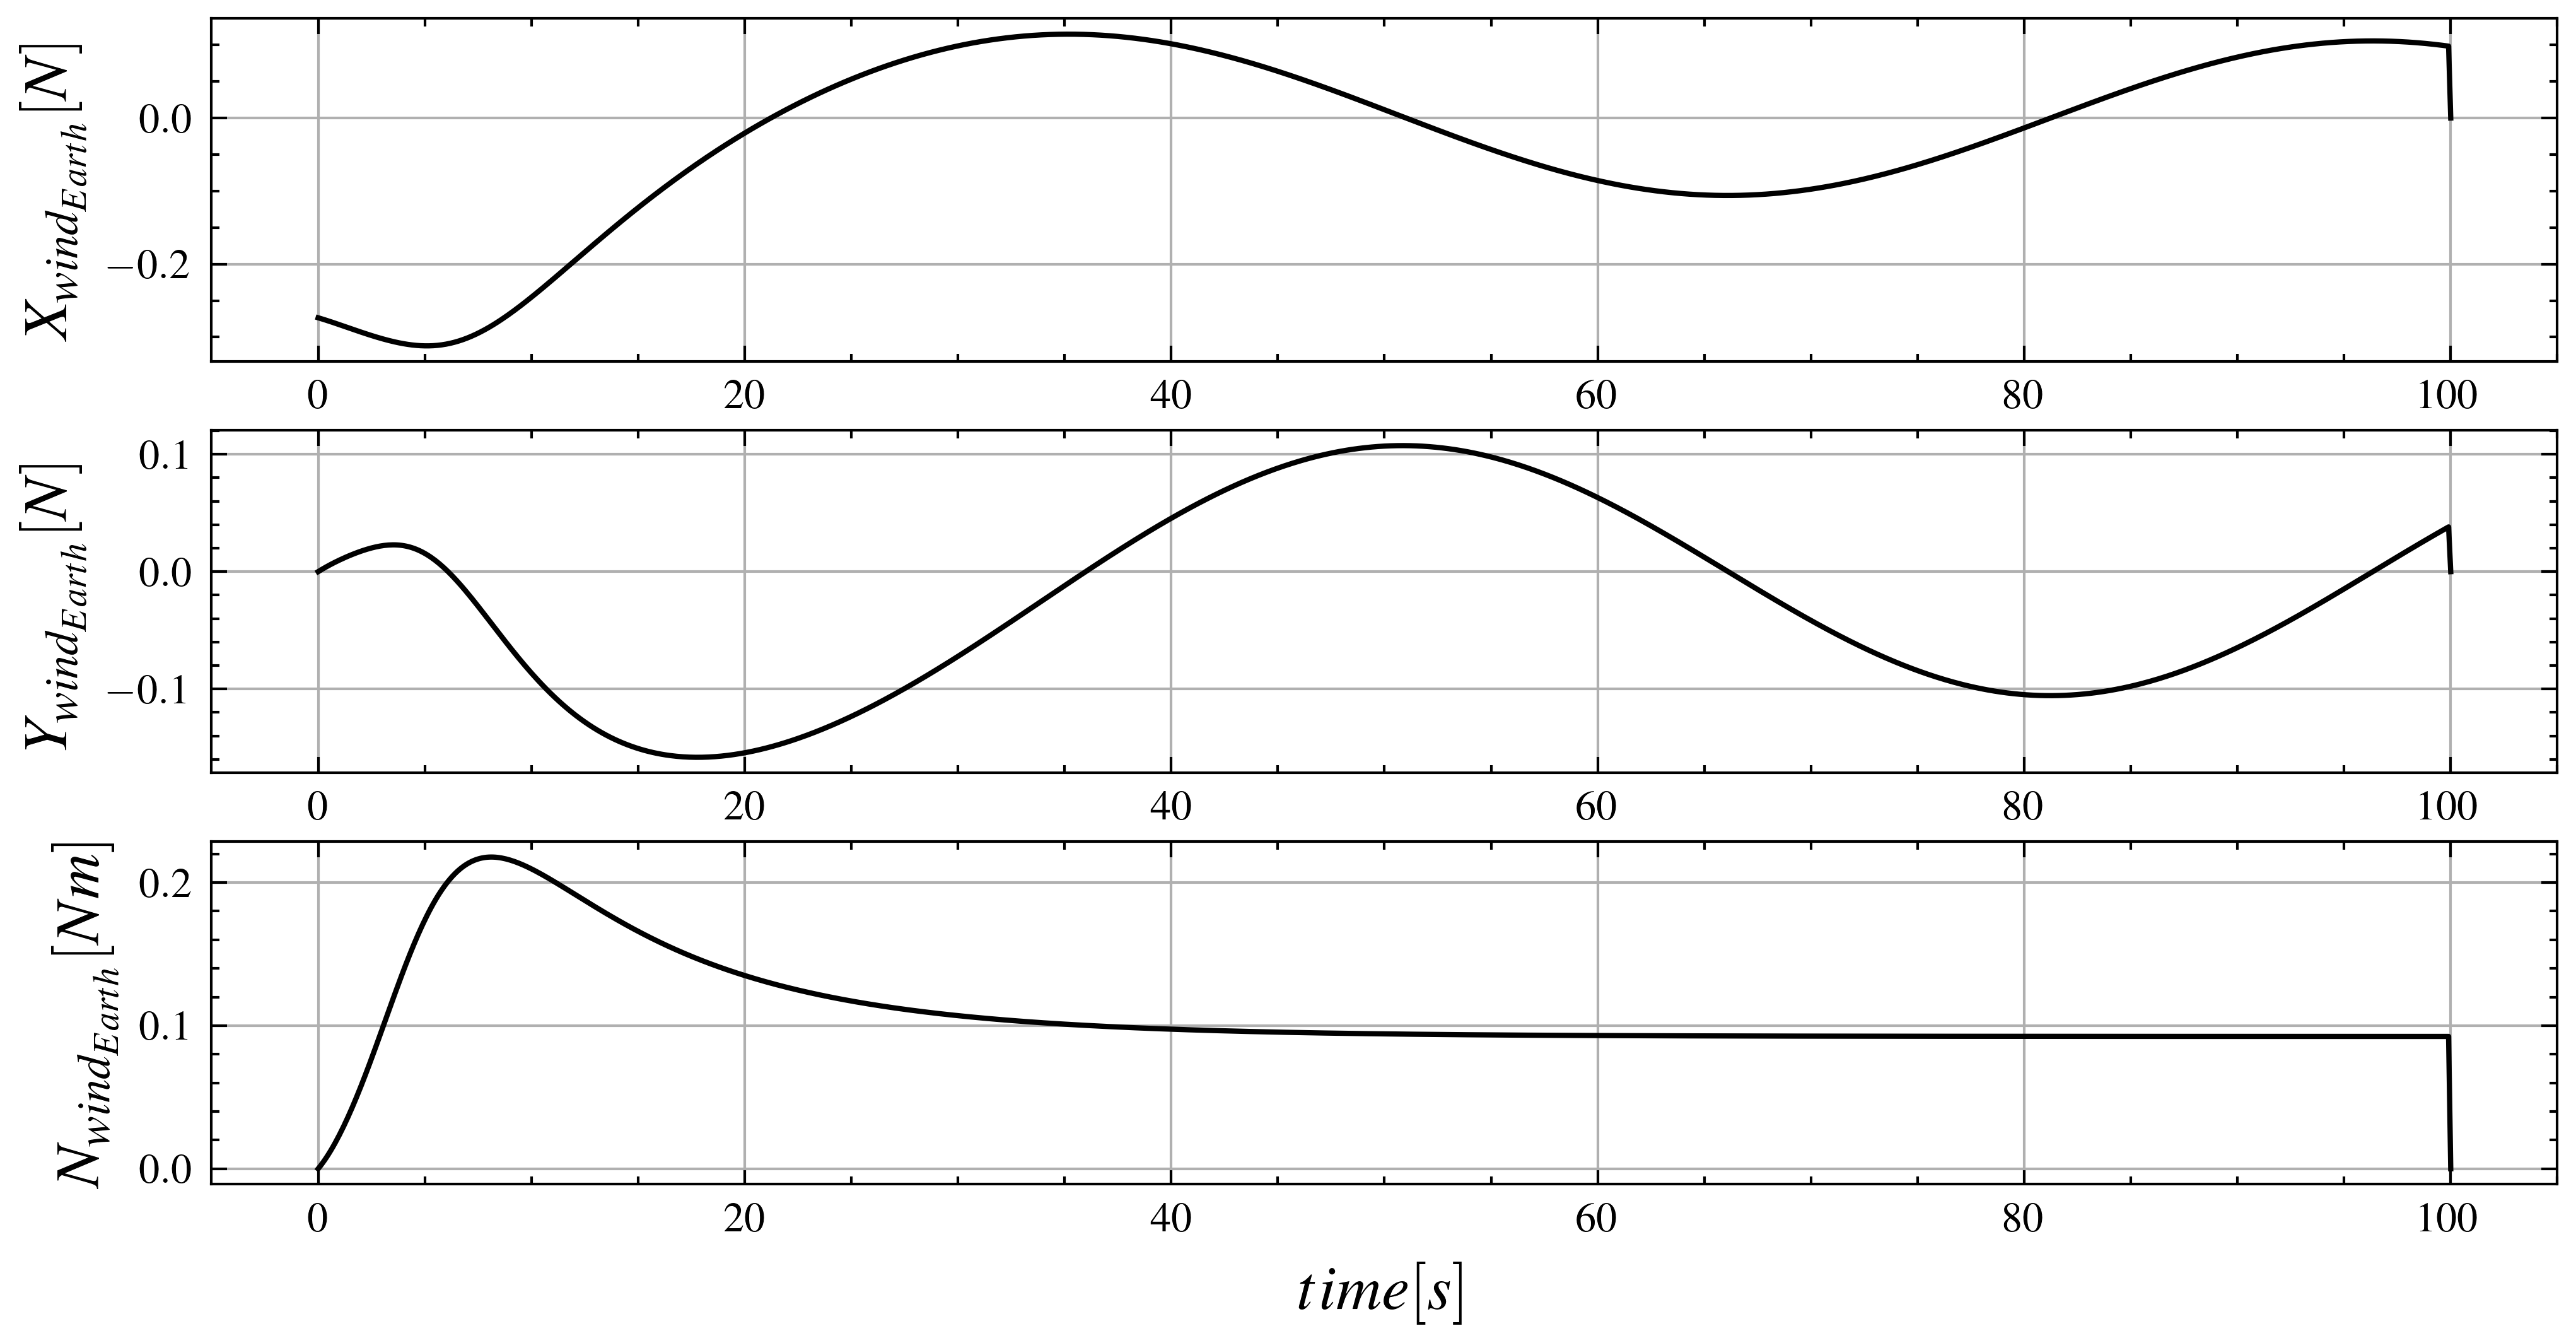

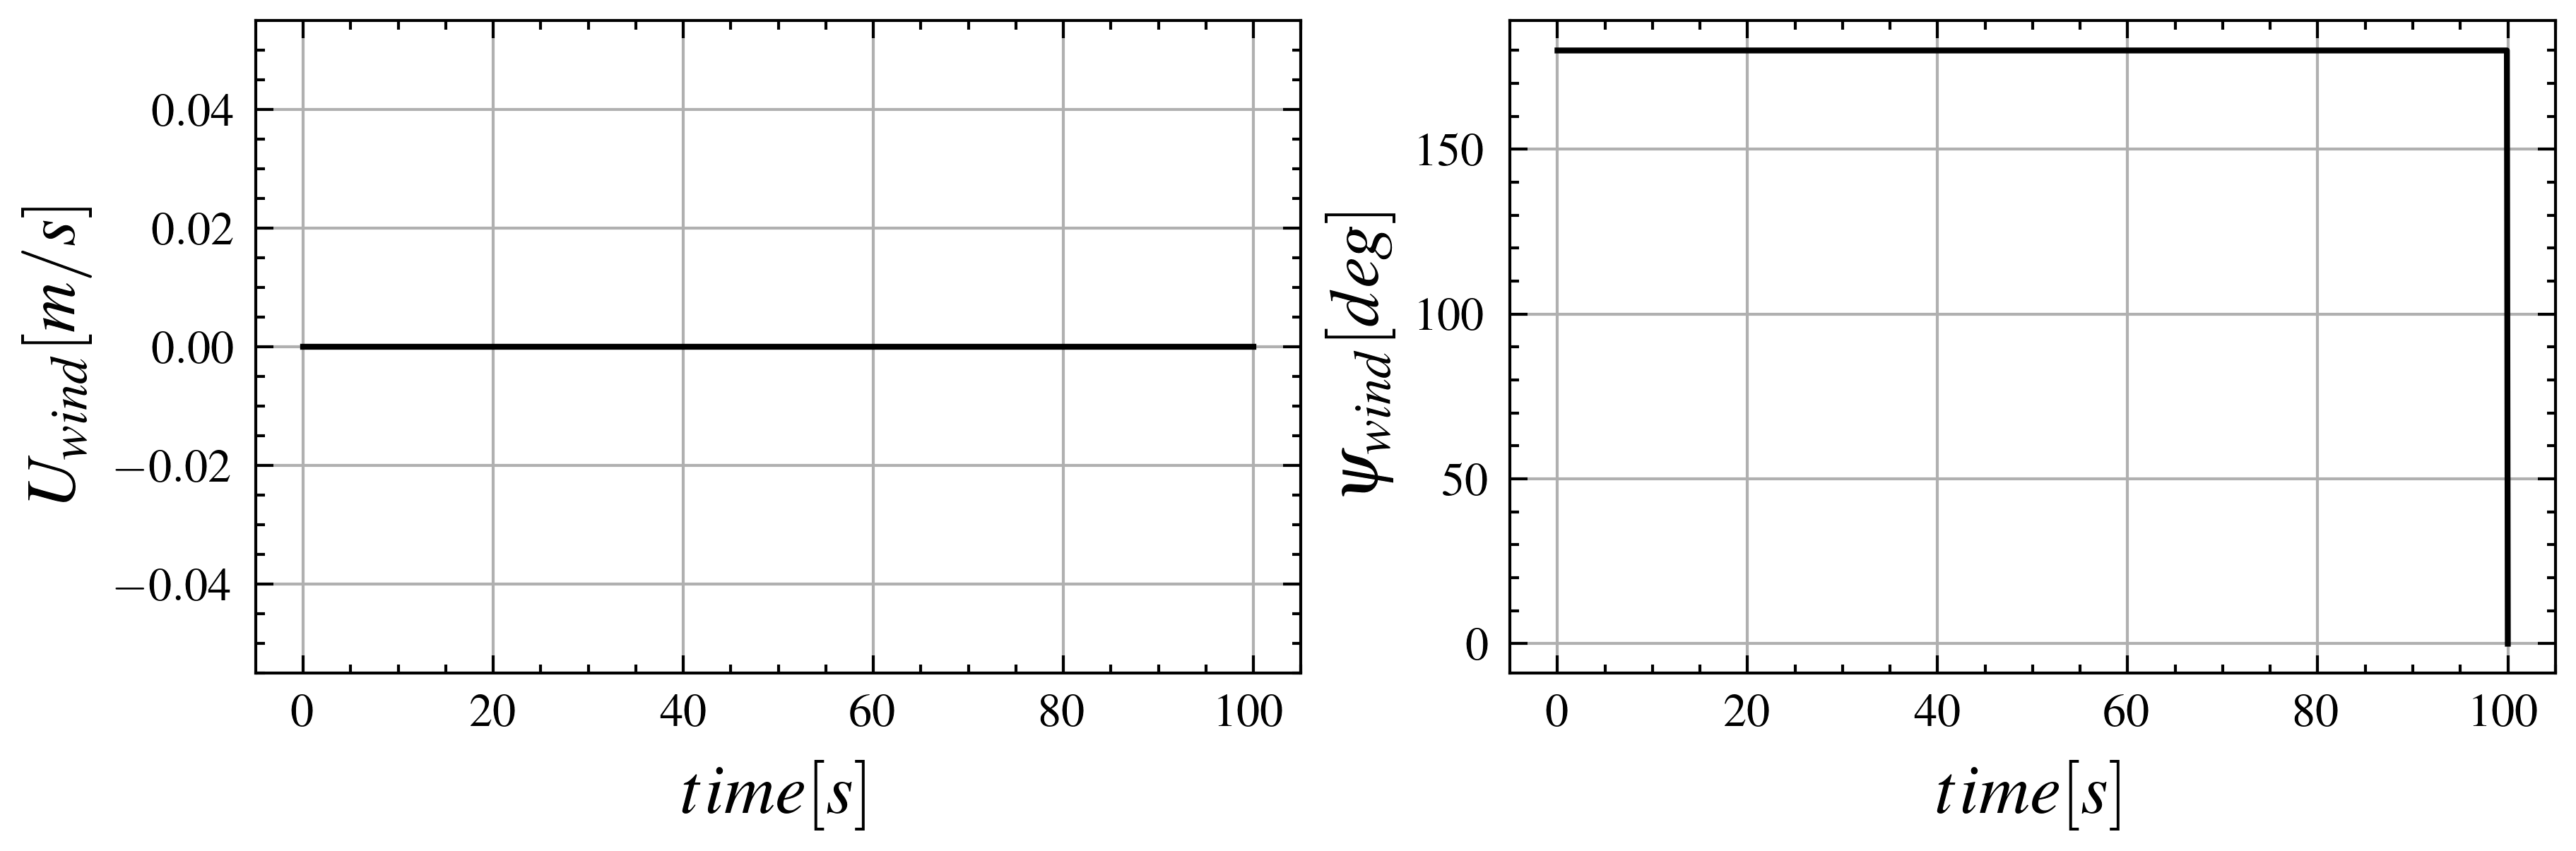

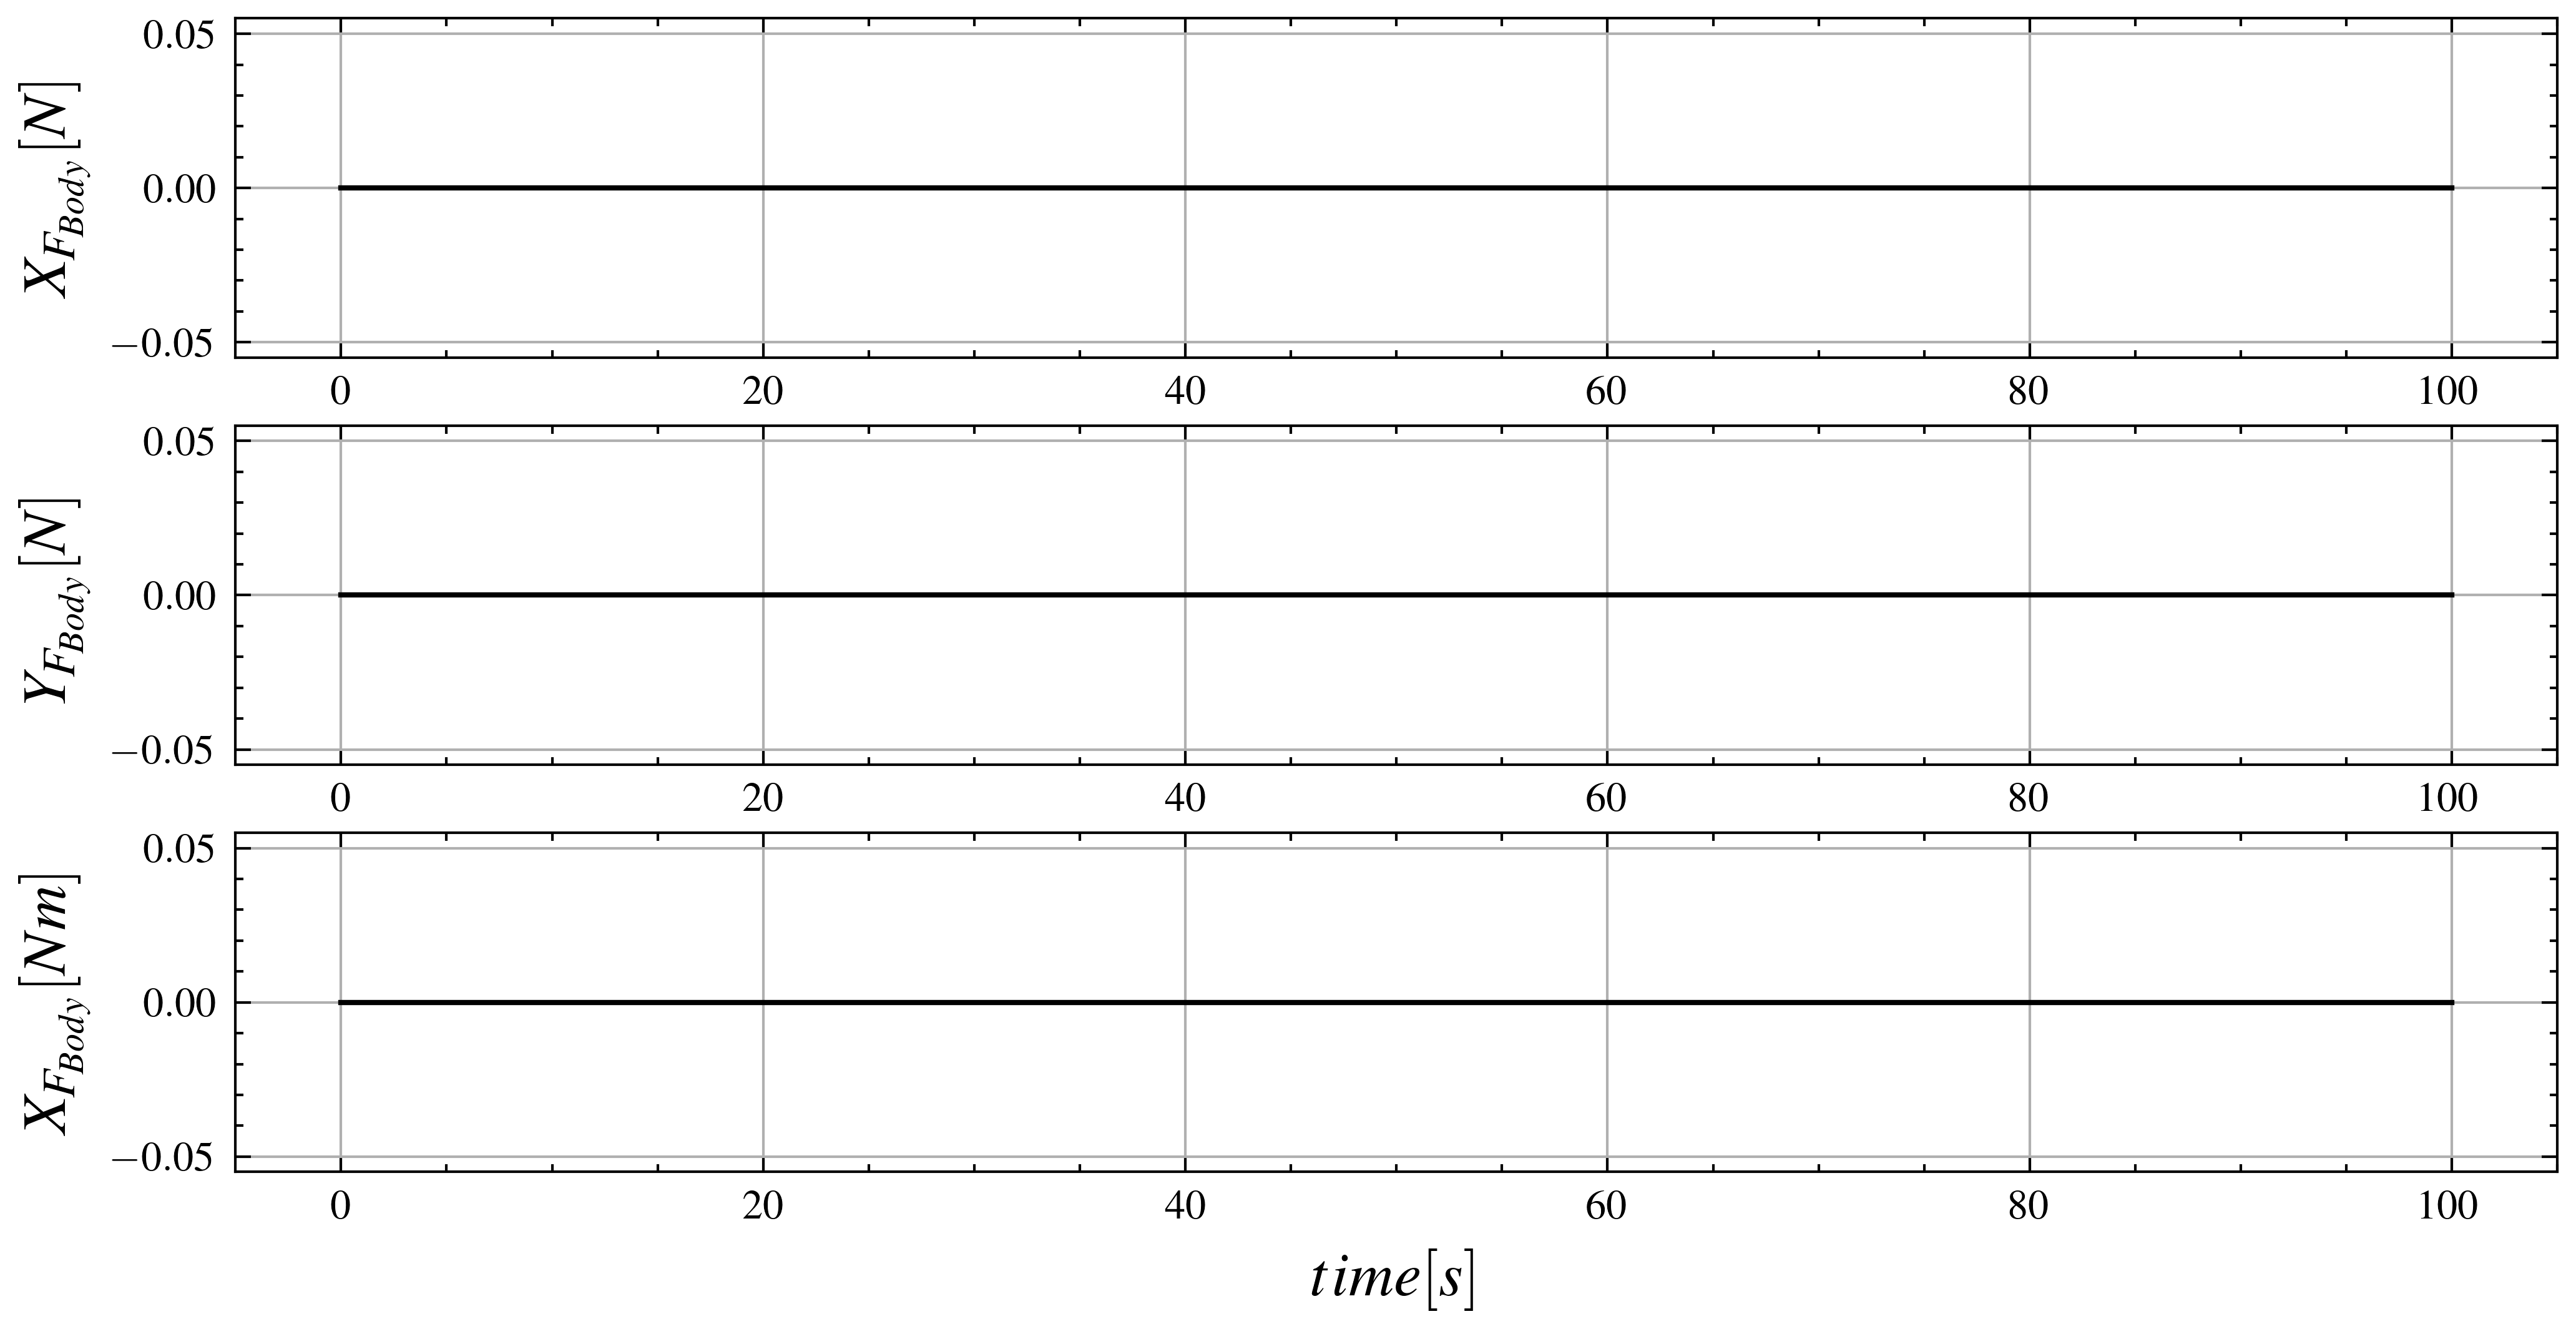

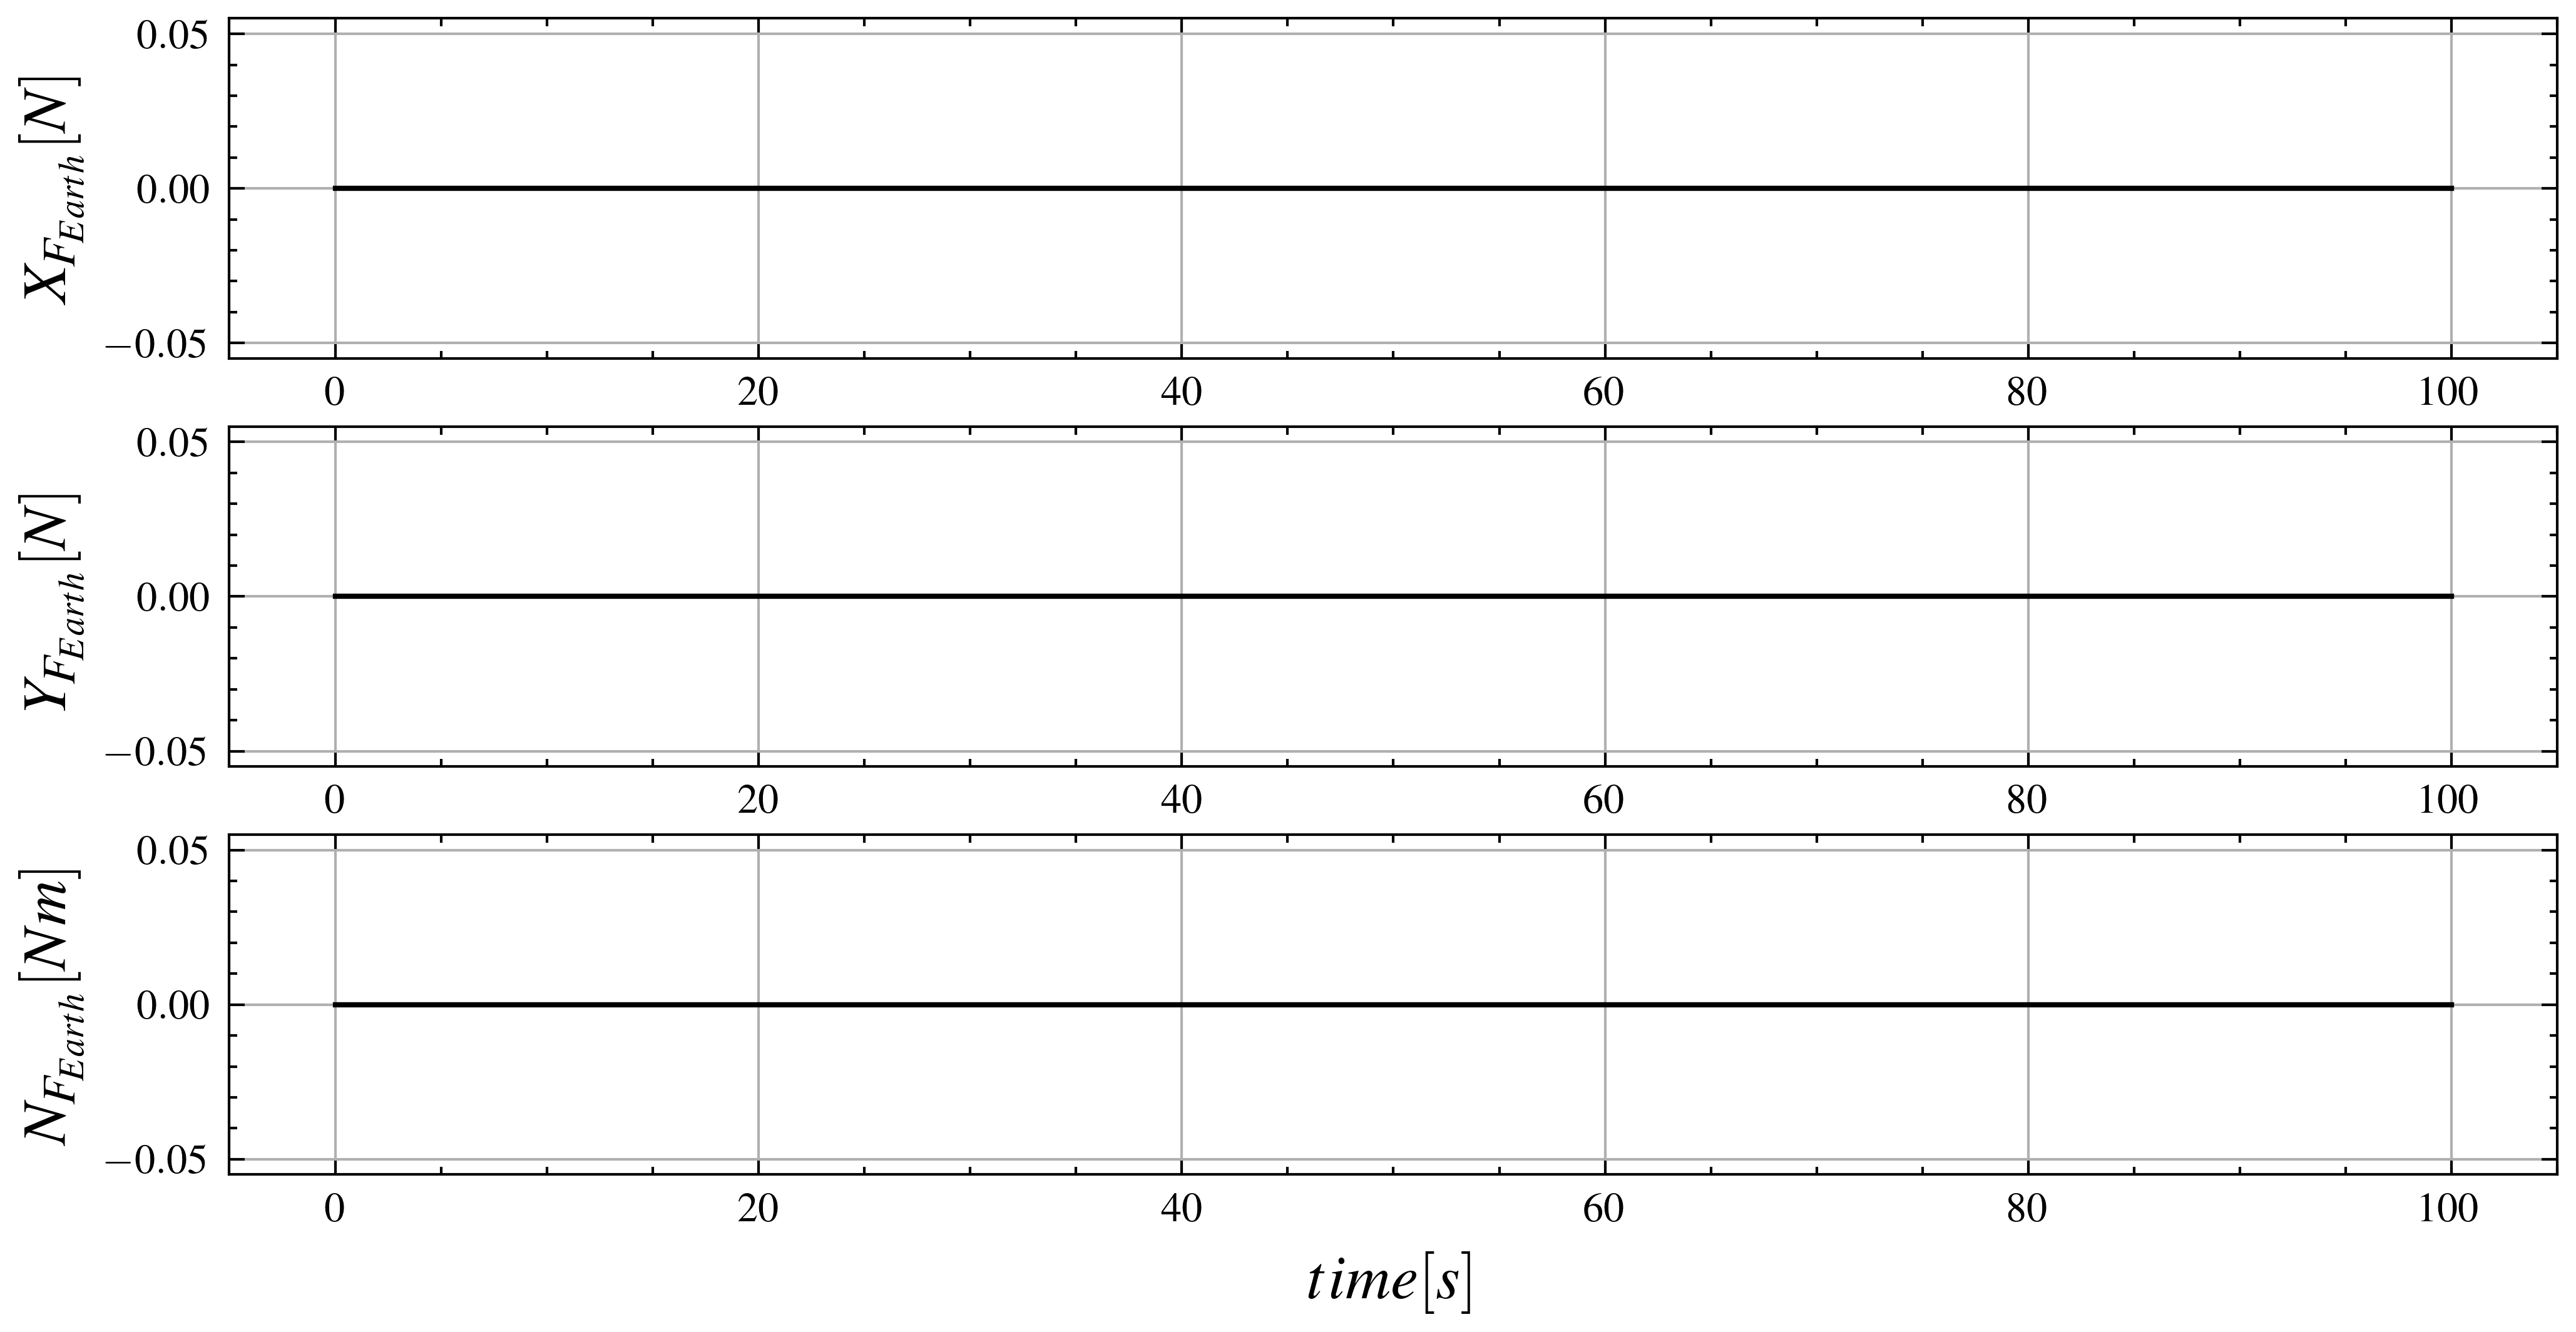

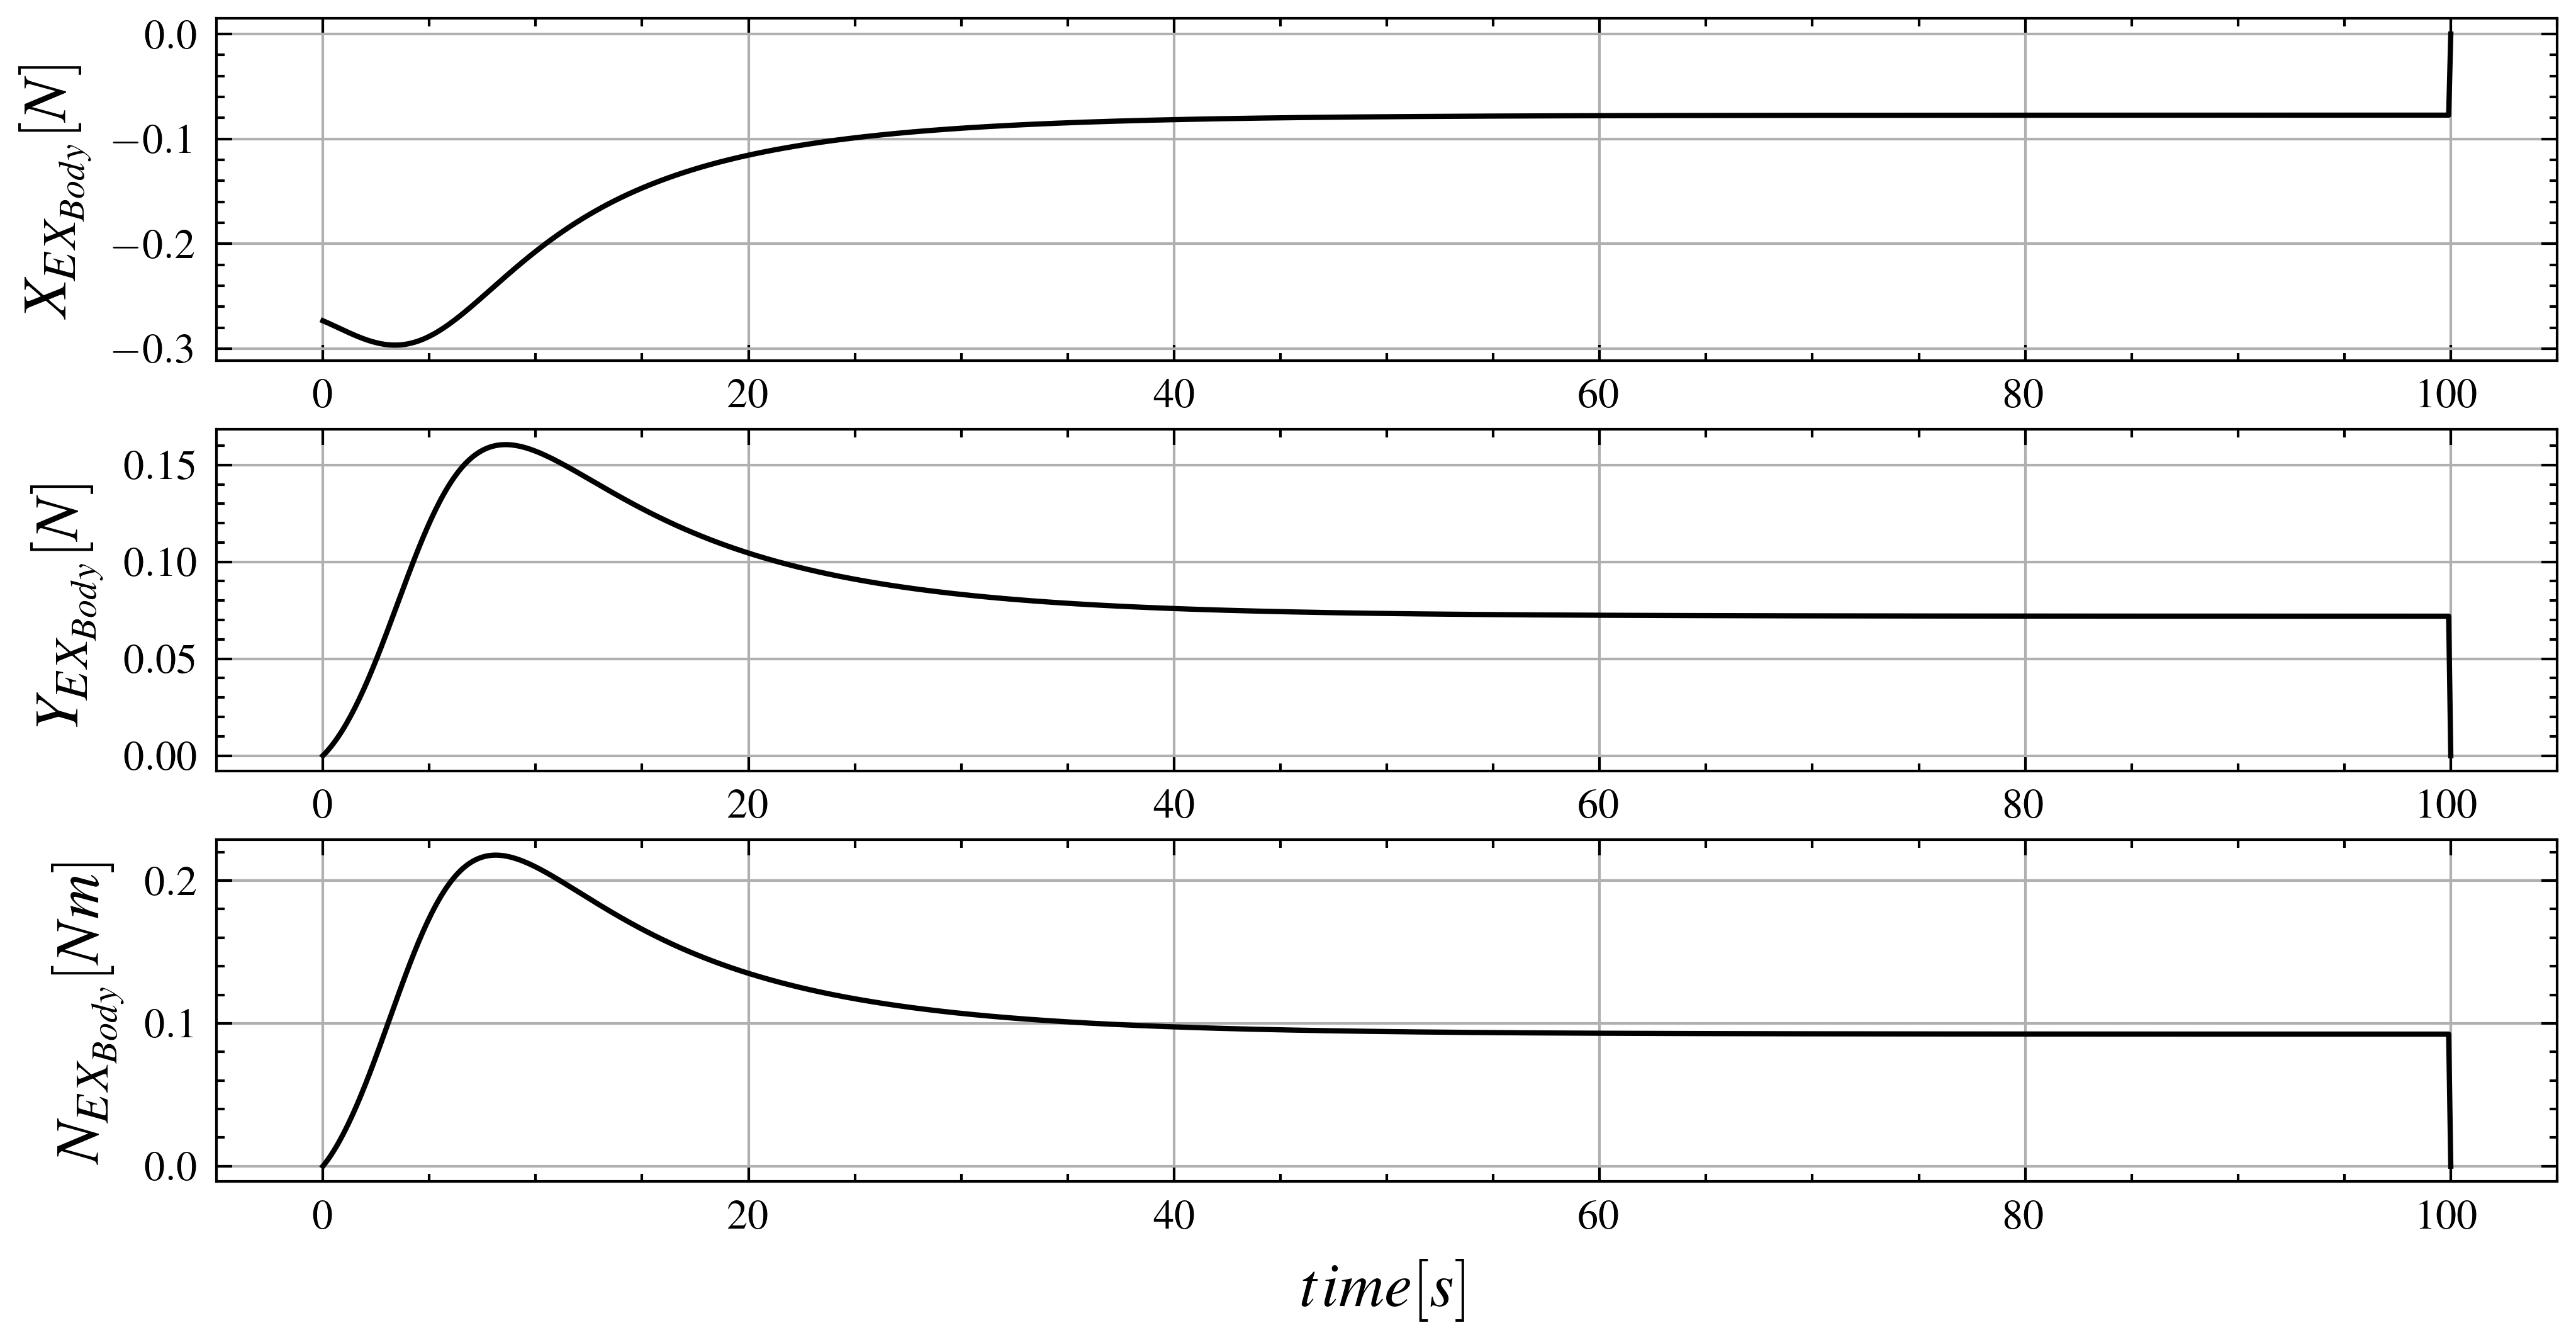

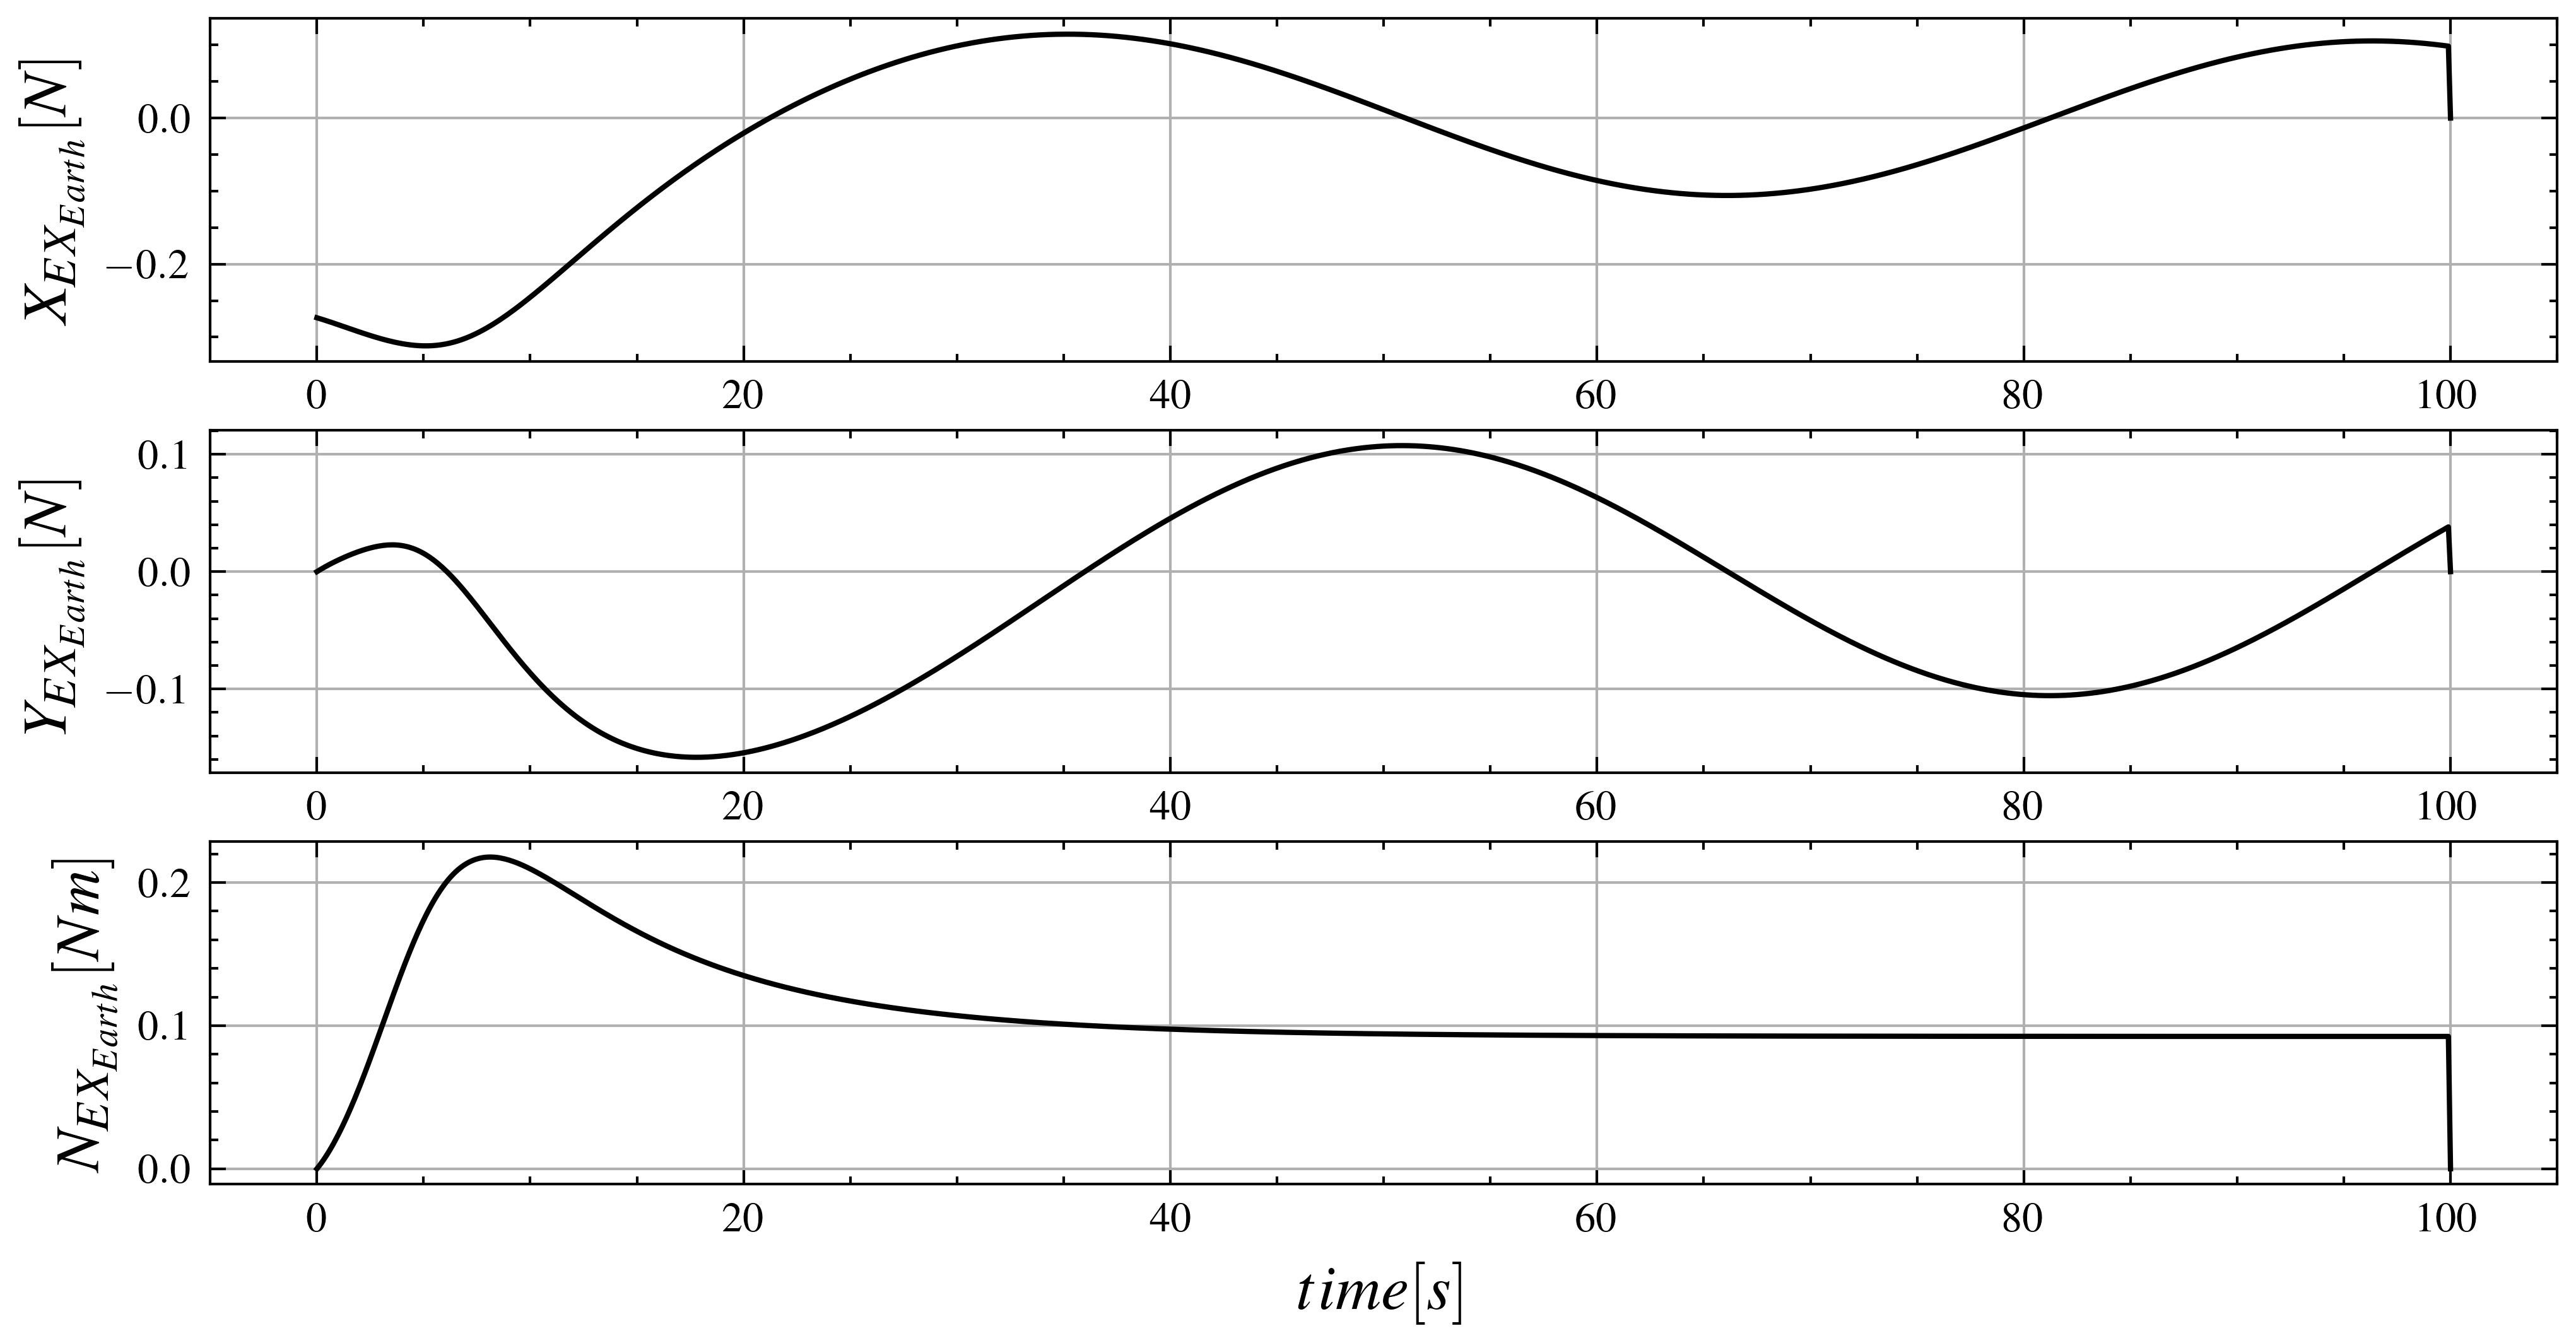

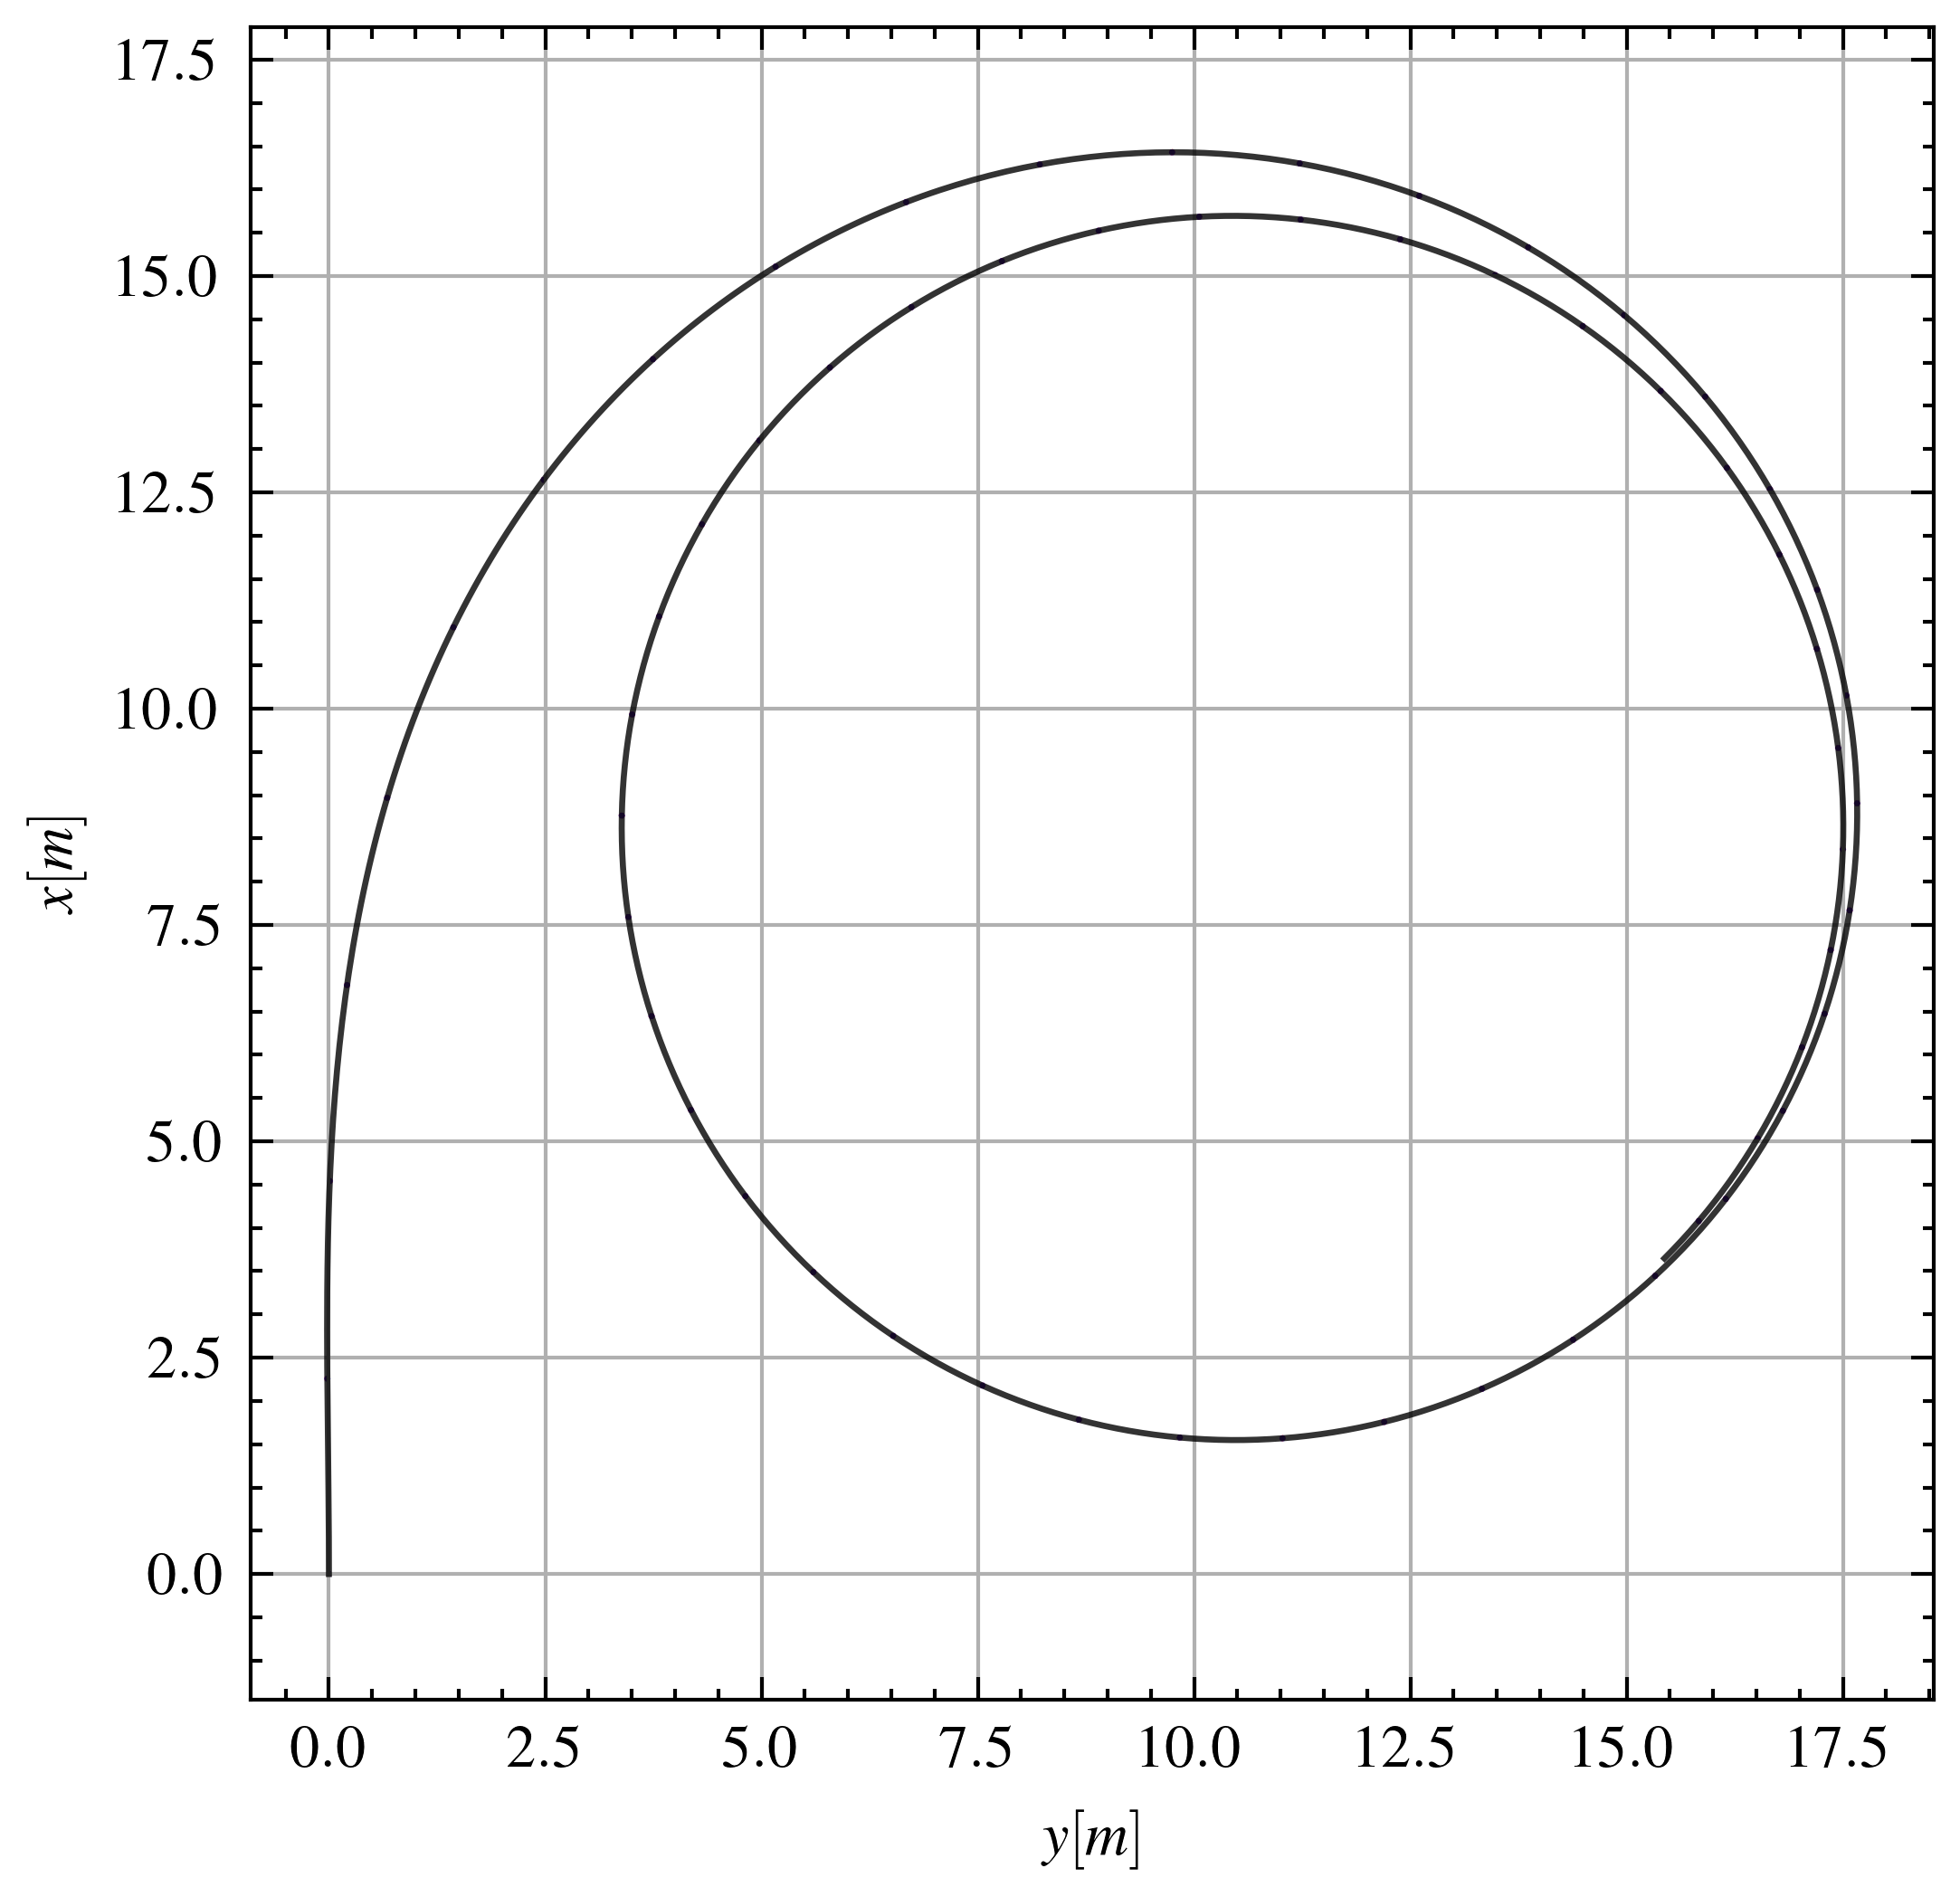

In [30]:
plt.style.use(["science", "ieee"])

fig = plt.figure(figsize=(2,2))
ax = fig.add_subplot(1, 1, 1)
ax.plot(obs[!,"y"], obs[!,"x"], "-", label="observation", c="k", alpha=0.8, linewidth=0.8)
ax.set_ylabel(L"x[m]", fontsize=10)
ax.set_xlabel(L"y[m]", fontsize=10)
# ax.legend(frameon=true, loc="lower right", fontsize=8)
ax.axis("equal")
ax.grid()
display(fig)

fig = plt.figure(figsize=(7,2))
ax = fig.add_subplot(1, 2, 1)
ax.plot(obs[!,"time"], obs[!,"δ"]./pi.*180, "-", c="k", linewidth=1)
ax.set_ylabel(L"\delta[deg]", fontsize=12)
ax.set_xlabel(L"time[s]", fontsize=12)
ax.grid()
ax = fig.add_subplot(1, 2, 2)
ax.plot(obs[!,"time"], obs[!,"n_p"], "-", c="k", linewidth=1)
ax.set_ylabel(L"n_p[rps]", fontsize=12)
ax.set_ylim(0.0,30)
ax.grid()
ax.set_xlabel(L"time[s]", fontsize=12)
display(fig)

fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(3, 1, 1)
ax.plot(obs[!,"time"], obs[!,"u"], "-", c="k", linewidth=1)
ax.set_ylabel(L"u[m/s]", fontsize=12)
ax.grid()
ax = fig.add_subplot(3, 1, 2)
ax.plot(obs[!,"time"], obs[!,"v"], "-", c="k", linewidth=1)
ax.set_ylabel(L"v[m/s]", fontsize=12)
ax.grid()
ax = fig.add_subplot(3, 1, 3)
ax.plot(obs[!,"time"], obs[!,"r"], "-", c="k", linewidth=1)
ax.set_ylabel(L"r[rad/s]", fontsize=12)
ax.set_xlabel(L"time[s]", fontsize=12)
ax.grid()
display(fig)

# fig = plt.figure(figsize=(5,1))
# ax = fig.add_subplot(1, 3, 1)
# # ax.plot(obs[!,"time"], obs[!,"u"],label=L"u[m/s]", "-", c="k", linewidth=1)
# ax.plot(obs[!,"time"], obs[!,"u"].+rand(Normal(0.0,0.08), 101),label=L"u[m/s]", ".", c="0.6", markersize=2)
# ax.legend(frameon=true, fontsize=9)
# ax.set_xlabel(L"time[s]", fontsize=9)
# ax.grid()

# ax = fig.add_subplot(1, 3, 2)
# # ax.plot(obs[!,"time"], obs[!,"v"], label=L"v[m/s]", "-", c="k", linewidth=1)
# ax.plot(obs[!,"time"], obs[!,"v"].+rand(Normal(0.0,0.04), 101), label=L"v[m/s]", ".", c="0.6", markersize=2)
# ax.legend(frameon=true, fontsize=9)
# ax.set_xlabel(L"time[s]", fontsize=9)
# ax.grid()

# ax = fig.add_subplot(1, 3, 3)
# # ax.plot(obs[!,"time"], obs[!,"r"], label=L"r[rad/s]", "-", c="k", linewidth=1)
# ax.plot(obs[!,"time"], obs[!,"r"].+rand(Normal(0.0,0.008), 101), label=L"r[rad/s]", ".", c="0.6", markersize=2)
# ax.legend(frameon=true, fontsize=9)
# ax.set_xlabel(L"time[s]", fontsize=9)
# ax.grid()
# display(fig)

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(3, 1, 1)
ax.plot(obs[!,"time"], obs[!,"X_wind"], "-", c="k", linewidth=1)
ax.set_ylabel(L"X_{wind_{Body}}[N]", fontsize=12)
# 
#ax.set_xlim(-5, 55)
ax.grid()
ax = fig.add_subplot(3, 1, 2)
ax.plot(obs[!,"time"], obs[!,"Y_wind"], "-", c="k", linewidth=1)
ax.set_ylabel(L"Y_{wind_{Body}}[N]", fontsize=12)
# 
#ax.set_xlim(-5, 55)
ax.grid()
ax = fig.add_subplot(3, 1, 3)
ax.plot(obs[!,"time"], obs[!,"N_wind"], "-", c="k", linewidth=1)
ax.set_ylabel(L"N_{wind_{Body}}[Nm]", fontsize=12)
# 
ax.set_xlabel(L"time[s]", fontsize=12)
ax.grid()
display(fig)

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(3, 1, 1)
ax.plot(obs[!,"time"], obs[!,"X_wind"].*cos.(obs[!,"ψ"]).-obs[!,"Y_wind"].*sin.(obs[!,"ψ"]), "-", c="k", linewidth=1)
ax.set_ylabel(L"X_{wind_{Earth}}[N]", fontsize=12)
# 
#ax.set_xlim(-5, 55)
ax.grid()
ax = fig.add_subplot(3, 1, 2)
ax.plot(obs[!,"time"], obs[!,"X_wind"].*sin.(obs[!,"ψ"]).+obs[!,"Y_wind"].*cos.(obs[!,"ψ"]), "-", c="k", linewidth=1)
ax.set_ylabel(L"Y_{wind_{Earth}}[N]", fontsize=12)
# 
#ax.set_xlim(-5, 55)
ax.grid()
ax = fig.add_subplot(3, 1, 3)
ax.plot(obs[!,"time"], obs[!,"N_wind"], "-", c="k", linewidth=1)
ax.set_ylabel(L"N_{wind_{Earth}}[Nm]", fontsize=12)
# 
ax.set_xlabel(L"time[s]", fontsize=12)
ax.grid()
display(fig)

fig = plt.figure(figsize=(7,2))
ax = fig.add_subplot(1, 2, 1)
ax.plot(obs[!,"time"], obs[!,"U_W"], "-", c="k", linewidth=1)
# ax.plot(obs[!,"time"], obs[!,"U_W"].+rand(Normal(0.0,0.1), 101), ".", c="0.6", markersize=2)
ax.set_ylabel(L"U_{wind}[m/s]", fontsize=12)
ax.set_xlabel(L"time[s]", fontsize=12)
ax.grid()
ax = fig.add_subplot(1, 2, 2)
ax.plot(obs[!,"time"], obs[!,"Ψ_W"]./pi.*180, "-", c="k", linewidth=1)
# ax.plot(obs[!,"time"], obs[!,"Ψ_W"]./pi.*180 .+rand(Normal(0.0,10.0), 101), ".", c="0.6", markersize=2)
ax.set_ylabel(L"\psi_{wind}[deg]", fontsize=12)
ax.grid()
ax.set_xlabel(L"time[s]", fontsize=12)
display(fig)

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(3, 1, 1)
ax.plot(obs[!,"time"], obs[!,"X_F"], "-", c="k", linewidth=1)
ax.set_ylabel(L"X_{F_{Body}}[N]", fontsize=12)

#ax.set_xlim(-5, 55)
ax.grid()
ax = fig.add_subplot(3, 1, 2)
ax.plot(obs[!,"time"], obs[!,"Y_F"], "-", c="k", linewidth=1)
ax.set_ylabel(L"Y_{F_{Body}}[N]", fontsize=12)

#ax.set_xlim(-5, 55)
ax.grid()
ax = fig.add_subplot(3, 1, 3)
ax.plot(obs[!,"time"], obs[!,"N_F"], "-", c="k", linewidth=1)
ax.set_ylabel(L"X_{F_{Body}}[Nm]", fontsize=12)

ax.set_xlabel(L"time[s]", fontsize=12)
ax.grid()
display(fig)

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(3, 1, 1)
ax.plot(obs[!,"time"], obs[!,"X_F"].*cos.(obs[!,"ψ"]).-obs[!,"Y_F"].*sin.(obs[!,"ψ"]), "-", c="k", linewidth=1)
ax.set_ylabel(L"X_{F_{Earth}}[N]", fontsize=12)

#ax.set_xlim(-5, 55)
ax.grid()
ax = fig.add_subplot(3, 1, 2)
ax.plot(obs[!,"time"], obs[!,"X_F"].*sin.(obs[!,"ψ"]).+obs[!,"Y_F"].*cos.(obs[!,"ψ"]), "-", c="k", linewidth=1)
ax.set_ylabel(L"Y_{F_{Earth}}[N]", fontsize=12)

#ax.set_xlim(-5, 55)
ax.grid()
ax = fig.add_subplot(3, 1, 3)
ax.plot(obs[!,"time"], obs[!,"N_F"], "-", c="k", linewidth=1)
ax.set_ylabel(L"N_{F_{Earth}}[Nm]", fontsize=12)

ax.set_xlabel(L"time[s]", fontsize=12)
ax.grid()
display(fig)

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(3, 1, 1)
ax.plot(obs[!,"time"], obs[!,"X_wind"]+obs[!,"X_F"], "-", c="k", linewidth=1)
ax.set_ylabel(L"X_{EX_{Body}}[N]", fontsize=12)
# ax.set_ylim(-3,3)

#ax.set_xlim(-5, 55)
ax.grid()
ax = fig.add_subplot(3, 1, 2)
ax.plot(obs[!,"time"], obs[!,"Y_wind"]+obs[!,"Y_F"], "-", c="k", linewidth=1)
ax.set_ylabel(L"Y_{EX_{Body}}[N]", fontsize=12)

#ax.set_xlim(-5, 55)
ax.grid()
ax = fig.add_subplot(3, 1, 3)
ax.plot(obs[!,"time"], obs[!,"N_wind"]+obs[!,"N_F"], "-", c="k", linewidth=1)
ax.set_ylabel(L"N_{EX_{Body}}[Nm]", fontsize=12)

ax.set_xlabel(L"time[s]", fontsize=12)
ax.grid()
display(fig)

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(3, 1, 1)
ax.plot(obs[!,"time"], (obs[!,"X_wind"].+obs[!,"X_F"]).*cos.(obs[!,"ψ"]).-(obs[!,"Y_wind"].+obs[!,"Y_F"]).*sin.(obs[!,"ψ"]), "-", c="k", linewidth=1)
ax.set_ylabel(L"X_{EX_{Earth}}[N]", fontsize=12)

#ax.set_xlim(-5, 55)
ax.grid()
ax = fig.add_subplot(3, 1, 2)
ax.plot(obs[!,"time"], (obs[!,"X_wind"].+obs[!,"X_F"]).*sin.(obs[!,"ψ"]).+(obs[!,"Y_wind"].+obs[!,"Y_F"]).*cos.(obs[!,"ψ"]), "-", c="k", linewidth=1)
ax.set_ylabel(L"Y_{EX_{Earth}}[N]", fontsize=12)

#ax.set_xlim(-5, 55)
ax.grid()
ax = fig.add_subplot(3, 1, 3)
ax.plot(obs[!,"time"], obs[!,"N_wind"], "-", c="k", linewidth=1)
ax.set_ylabel(L"N_{EX_{Earth}}[Nm]", fontsize=12)

ax.set_xlabel(L"time[s]", fontsize=12)
ax.grid()
display(fig)

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1, 1, 1)
skip = 16
scale = 12
width = 0.004
alpha = 0.6
ax.quiver(obs[1:skip:whole_step,"y"], obs[1:skip:whole_step,"x"], obs[1:skip:whole_step,"Y_wind"].*cos.(obs[1:skip:whole_step,"ψ"]).+obs[1:skip:whole_step,"X_wind"].*sin.(obs[1:skip:whole_step,"ψ"]), .-obs[1:skip:whole_step,"Y_wind"].*sin.(obs[1:skip:whole_step,"ψ"])+obs[1:skip:whole_step,"X_wind"].*cos.(obs[1:skip:whole_step,"ψ"]), angles="xy", scale_units="xy" ,scale=scale, width=width,color="red", alpha=alpha)
ax.quiver(obs[1:skip:whole_step,"y"], obs[1:skip:whole_step,"x"], obs[1:skip:whole_step,"Y_F"].*cos.(obs[1:skip:whole_step,"ψ"]).+obs[1:skip:whole_step,"X_F"].*sin.(obs[1:skip:whole_step,"ψ"]), .-obs[1:skip:whole_step,"Y_F"].*sin.(obs[1:skip:whole_step,"ψ"])+obs[1:skip:whole_step,"X_F"].*cos.(obs[1:skip:whole_step,"ψ"]), angles="xy", scale_units="xy" ,scale=scale, width=width,color="blue", alpha=alpha)
ax.plot(obs[!,"y"], obs[!,"x"], "-", label="observation", c="k", alpha=0.8, linewidth=0.8)
ax.set_ylabel(L"x[m]", fontsize=8)
ax.set_xlabel(L"y[m]", fontsize=8)
# ax.legend(frameon=true, loc="lower right", fontsize=6)
# # ax.set_ylim(-1, 9)
# # ax.set_xlim(-3, 12)
# # ax.set_ylim(-7, 13)
# # ax.set_xlim(-7, 23)
# # ax.set_ylim(-5,75)
# # ax.set_xlim(-20,60)
ax.set_xlim(-5,45)
ax.axis("equal")
ax.grid()
display(fig)